In [1]:
!pip install optuna
!pip install catboost
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00


In [2]:
import sklearn
sklearn.set_config(transform_output="pandas")

from pathlib import Path

import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import category_encoders as ce
import xgboost as xgb
import lightgbm as lgb
import optuna as opt
import catboost as cb
import optuna.integration.lightgbm as optlgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, RFECV, RFE
from sklearn.base import BaseEstimator, TransformerMixin, ClassNamePrefixFeaturesOutMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import silhouette_score, classification_report
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, brier_score_loss, log_loss, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.svm import SVC

from prettytable import PrettyTable

# Init

In [3]:
rng = np.random.RandomState(1234567890)

data_p = Path("/content/drive/MyDrive/Colab Notebooks/Data/Kaggle/PlaySmoking_S03E24")
train = pd.read_csv(data_p / "train.csv.gz")
test = pd.read_csv(data_p / "test.csv.gz")

train.columns = train.columns.str.replace(r"[\s+]", "_", regex=True).str.lower()
test.columns = test.columns.str.replace(r"[\s+]", "_", regex=True).str.lower()

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting_blood_sugar  159256 non-null  int64  
 12  cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  hdl                  159256 non-null  int64  
 15  ldl              

In [5]:
train.isnull().sum().sum()

0

In [6]:
train["smoking"].value_counts()

0    89603
1    69653
Name: smoking, dtype: int64

In [7]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=["id", "smoking"]), train["smoking"], test_size=0.2, stratify=train["smoking"], random_state=rng)
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
df_train = pd.concat([X_train, y_train.to_frame()], axis=1)
df_train.shape, y_train.shape, y_val.shape

((152940, 23), (127404,), (31852,))

# Data Analysis

In [8]:
X_train.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).round(2).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
age,127404.0,44.32,11.84,20.0,25.0,40.0,40.0,55.0,65.0,85.0
height(cm),127404.0,165.29,8.81,135.0,150.0,160.0,165.0,170.0,180.0,190.0
weight(kg),127404.0,67.16,12.57,30.0,50.0,60.0,65.0,75.0,90.0,130.0
waist(cm),127404.0,83.01,8.95,51.0,68.0,77.0,83.0,89.0,98.0,127.0
eyesight(left),127404.0,1.01,0.40,0.1,0.5,0.8,1.0,1.2,1.5,9.9
eyesight(right),127404.0,1.00,0.39,0.1,0.5,0.8,1.0,1.2,1.5,9.9
hearing(left),127404.0,1.02,0.15,1.0,1.0,1.0,1.0,1.0,1.0,2.0
hearing(right),127404.0,1.02,0.15,1.0,1.0,1.0,1.0,1.0,1.0,2.0
systolic,127404.0,122.51,12.73,77.0,101.0,114.0,121.0,130.0,144.0,213.0
relaxation,127404.0,76.87,9.00,44.0,61.0,70.0,78.0,82.0,91.0,133.0


In [9]:
nuniq = df_train.apply("nunique")
nuniq

age                     17
height(cm)              14
weight(kg)              27
waist(cm)              524
eyesight(left)          19
eyesight(right)         17
hearing(left)            2
hearing(right)           2
systolic               109
relaxation              74
fasting_blood_sugar    226
cholesterol            226
triglyceride           389
hdl                    105
ldl                    217
hemoglobin             134
urine_protein            6
serum_creatinine        27
ast                    131
alt                    180
gtp                    349
dental_caries            2
smoking                  2
dtype: int64

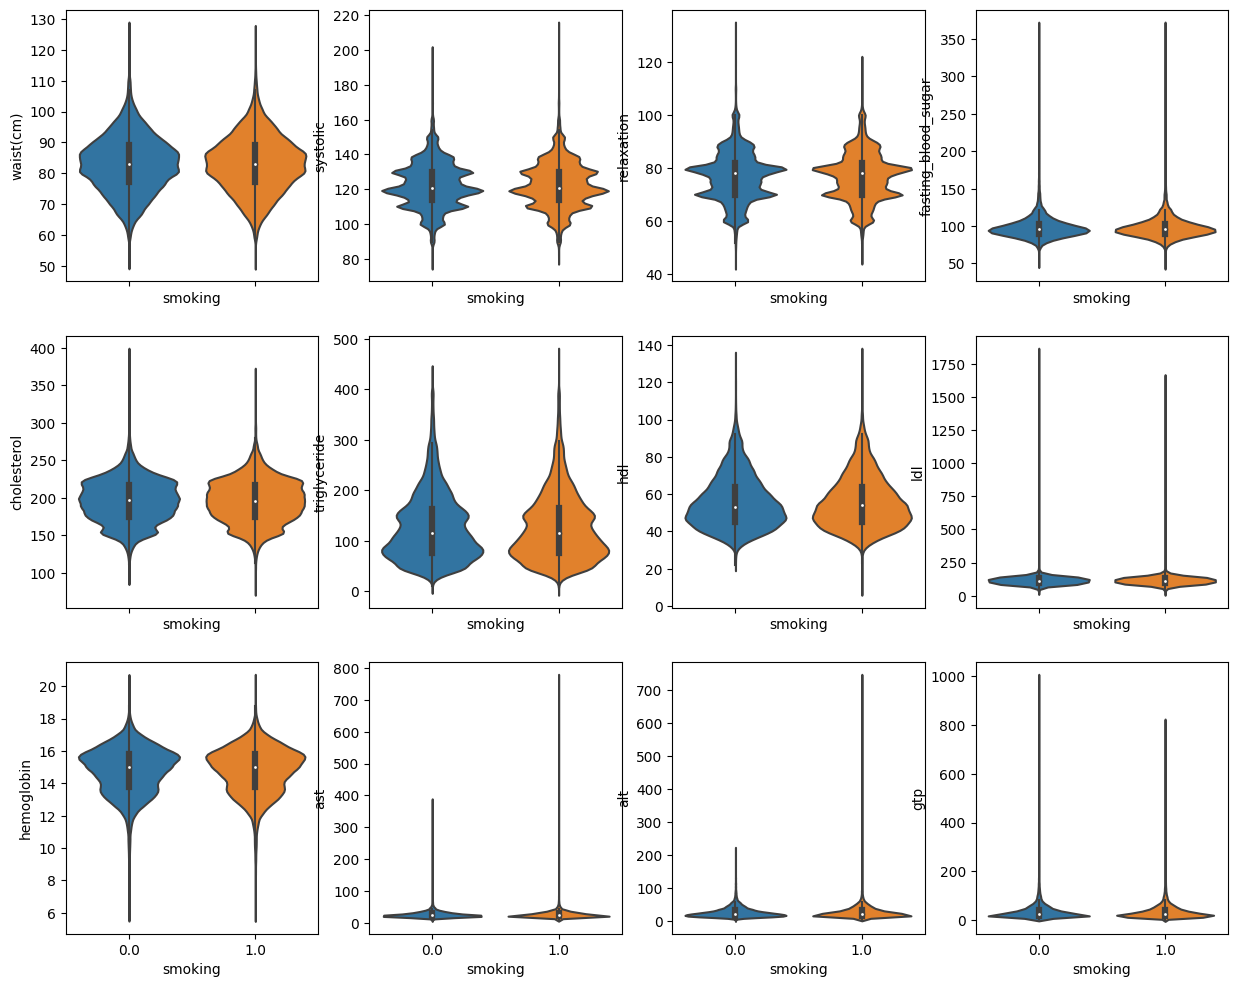

In [10]:
fig, ax = plt.subplots(3, 4, sharex=True, figsize=[15,12])

for i, c in enumerate(nuniq[nuniq >= 50].index.tolist()):
    g = sns.violinplot(data=df_train, x="smoking", y=c, ax=ax[int(i/4)][int(i%4)])

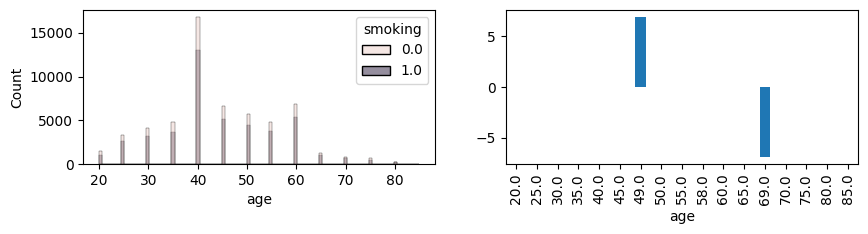

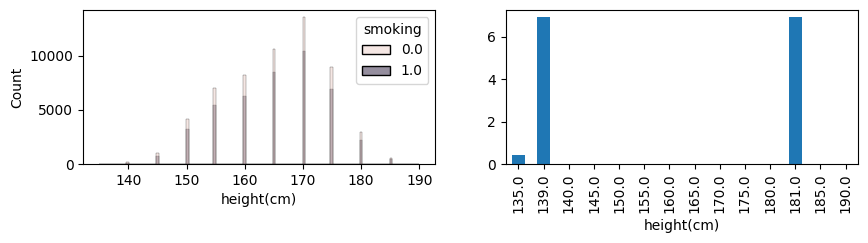

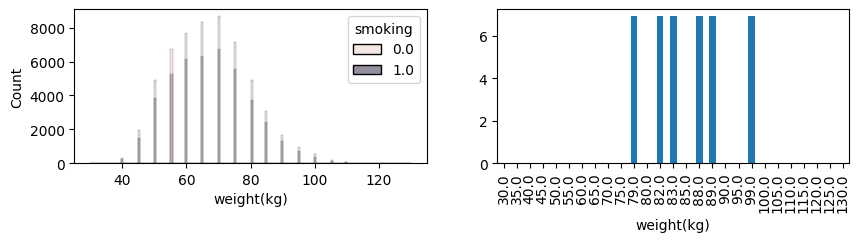

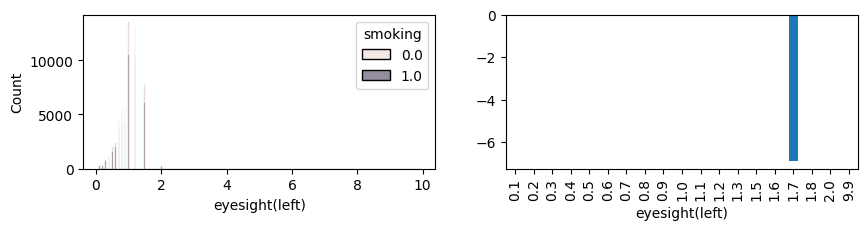

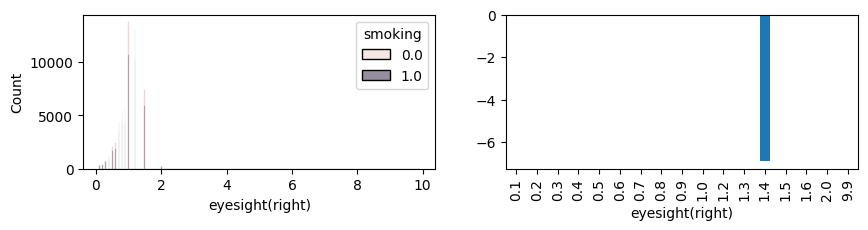

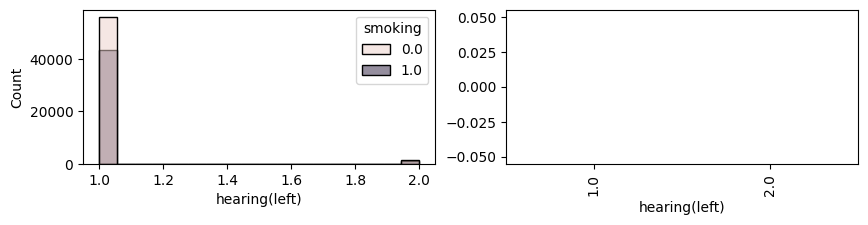

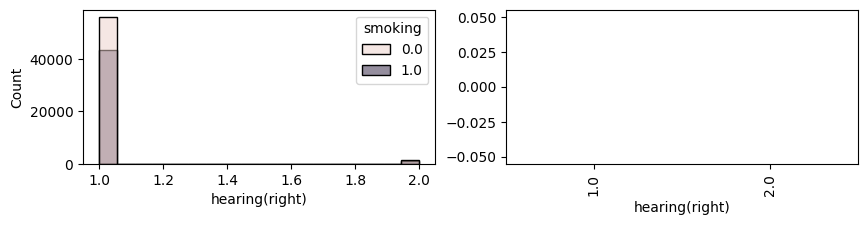

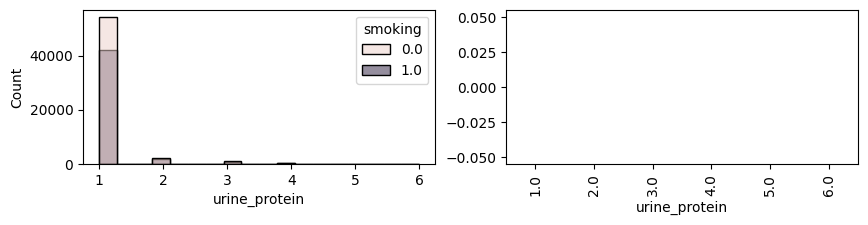

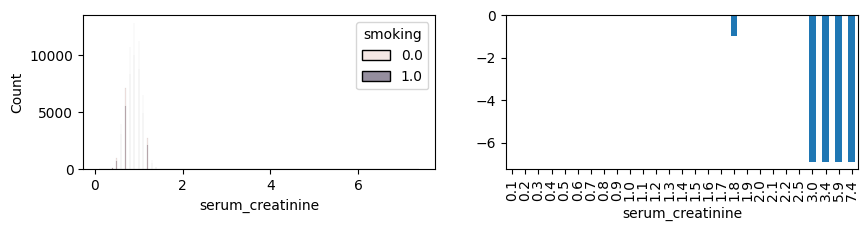

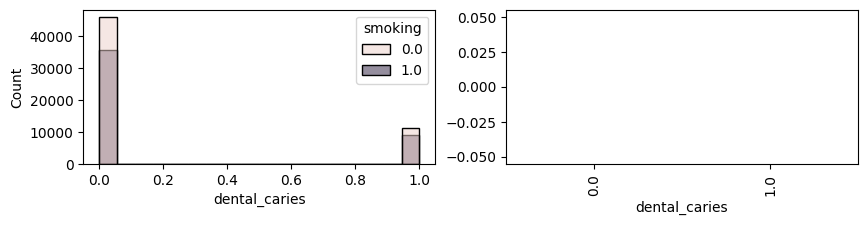

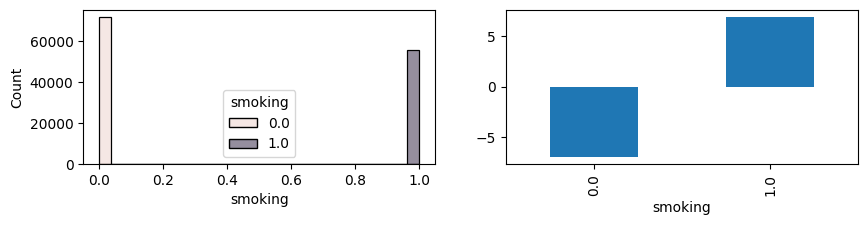

In [11]:
def logodds(x):
    if not len(x):
        return 0
    event_dist = sum(x["smoking"]) / len(x)
    non_event_dist = sum(x["smoking"] == 0) / len(x)

    return np.log((event_dist + 0.001) / (non_event_dist + 0.001))

for c in nuniq[nuniq < 50].index.tolist():
    fig, ax = plt.subplots(1, 2, figsize=[10, 2])

    _ = sns.histplot(data=df_train, x=c, ax=ax[0], hue="smoking")
    _ = df_train.groupby(c).apply(logodds).plot(kind="bar", ax=ax[1])

In [12]:
strong_corr = {}

X_corr = X_train.corr()

for c in X_corr.columns:
    this_corr = X_corr[c].drop(index=c)
    p, n = this_corr[this_corr >= 0.5].index.tolist(), this_corr[this_corr <= -0.5].index.tolist()
    if p or n:
        strong_corr[c] = {
            "+": p,
            "-": n
        }
strong_corr

{'height(cm)': {'+': ['weight(kg)', 'hemoglobin'], '-': []},
 'weight(kg)': {'+': ['height(cm)', 'waist(cm)', 'hemoglobin'], '-': []},
 'waist(cm)': {'+': ['weight(kg)'], '-': []},
 'hearing(left)': {'+': ['hearing(right)'], '-': []},
 'hearing(right)': {'+': ['hearing(left)'], '-': []},
 'systolic': {'+': ['relaxation'], '-': []},
 'relaxation': {'+': ['systolic'], '-': []},
 'cholesterol': {'+': ['ldl'], '-': []},
 'triglyceride': {'+': [], '-': ['hdl']},
 'hdl': {'+': [], '-': ['triglyceride']},
 'ldl': {'+': ['cholesterol'], '-': []},
 'hemoglobin': {'+': ['height(cm)', 'weight(kg)'], '-': []},
 'ast': {'+': ['alt'], '-': []},
 'alt': {'+': ['ast'], '-': []}}

In [13]:
mi = mutual_info_classif(X_train, y_train, discrete_features=nuniq.drop("smoking") < 10, n_neighbors=5, random_state=rng)
mi_tab = PrettyTable(field_names=["Variable", "Mutual Info"], sortby="Mutual Info", reversesort=True)
mi_tab.add_rows(list(zip(X_train.columns, np.round(mi, 4))))
print(mi_tab)

+---------------------+-------------+
|       Variable      | Mutual Info |
+---------------------+-------------+
|      height(cm)     |    0.1367   |
|      hemoglobin     |    0.1335   |
|         gtp         |    0.0997   |
|      weight(kg)     |    0.0804   |
|     triglyceride    |    0.0748   |
|   serum_creatinine  |    0.0617   |
|      waist(cm)      |    0.0445   |
|         hdl         |    0.0402   |
|         alt         |    0.028    |
|         age         |    0.0252   |
|      relaxation     |    0.0131   |
|   eyesight(right)   |    0.013    |
|    eyesight(left)   |    0.0119   |
| fasting_blood_sugar |    0.0111   |
|       systolic      |    0.0106   |
|         ldl         |    0.0097   |
|     cholesterol     |    0.0077   |
|    dental_caries    |    0.0053   |
|         ast         |    0.0028   |
|    hearing(left)    |    0.0007   |
|    hearing(right)   |    0.0006   |
|    urine_protein    |    0.0005   |
+---------------------+-------------+


# Feature Engineering

## Semantic engineering

In [14]:
def fteng(df):
    df["ft_bmi"] = df["weight(kg)"] / (df["height(cm)"] / 100)**2
    df["ft_tc_hdl_ratio"] = df["cholesterol"] / df["hdl"]
    df["ft_hearing(left)"] = df["hearing(left)"] - 1
    df["ft_hearing(right)"] = df["hearing(right)"] - 1

    df["ft_bin_age"] = pd.cut(df["age"], [0] + list(range(20, 66, 5)) + [9999], labels=False)
    df["ft_bin_height(cm)"] = pd.cut(df["height(cm)"], [0] + list(range(135, 181, 5)) + [9999], labels=False)
    df["ft_bin_weight(kg)"] = pd.cut(df["weight(kg)"], [0] + list(range(30, 101, 5)) + [9999], labels=False)
    df["ft_bin_serum_creatinine"] = pd.cut(df["serum_creatinine"], [0] + list(np.round(np.arange(0.1, 2.01, 0.1), 1)) + [9999], labels=False)
    df["ft_bin_urine_protein"] = pd.cut(df["urine_protein"], [0, 1, 2, 3, 4, 9999], labels=False)
    # "underweight", "normal", "overweight", "obese_g1", "obese_g2", "obese_g3"
    df["ft_bin_bmi"] = pd.cut(df["ft_bmi"], [0, 18.5, 25, 30, 35, 40, 9999], labels=[0, 1, 2, 3, 4, 5])
    df["tmp_systolic"] = pd.cut(df["systolic"], [0, 120, 130, 140, 180, 9999], labels=False)
    df["tmp_diastolic"] = pd.cut(df["relaxation"], [0, 80, 90, 100, 120, 9999], labels=False)
    # 0: "normal", 1: "elevated", 2: "bp_s1", 3: "bp_s2", 4: "bp_s3"
    df["ft_bin_blood_pressure_risk"] = df[["tmp_systolic", "tmp_diastolic"]].max(axis=1)
    # "normal", "borderline", "high"
    df["ft_bin_cholesterol_risk"] = pd.cut(df["cholesterol"], [0, 200, 240, 9999], labels=[0, 1, 2])
    # "high", "normal", "low"
    df["ft_bin_hdl_risk"] = pd.cut(df["hdl"], [0, 40, 60, 9999], labels=[2, 1, 0])
    # "best", "good", "borderline", "high", "very_high"
    df["ft_bin_ldl_risk"] = pd.cut(df["ldl"], [0, 100, 130, 160, 190, 9999], labels=[0, 1, 2, 3, 4])
    # "normal", "moderate", "high", "very_high"
    df["ft_bin_triglyceride_risk"] = pd.cut(df["triglyceride"], [0, 150, 200, 500, 9999], labels=[0, 1, 2, 3])
    # "low", "high"
    df["ft_bin_tc_hdl_ratio_risk"] = pd.cut(df["ft_tc_hdl_ratio"], [0, 5, 9999], labels=[0, 1])
    # "low", "normal", "high"
    df["ft_bin_gtp"] = pd.cut(df["gtp"], [0, 5, 40, 9999], labels=[0, 1, 2])

    todrop = ['age', 'height(cm)', 'weight(kg)', 'urine_protein', 'serum_creatinine', 'hearing(right)', 'hearing(left)']

    return df.drop(columns=df.columns[df.columns.str.contains("tmp_")].tolist() + todrop)

In [15]:
X_train = fteng(X_train)
df_train = pd.concat([X_train, y_train.to_frame("smoking")], axis=1)
X_val = fteng(X_val)
test = fteng(test)
X_train.columns

Index(['waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic',
       'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
       'hdl', 'ldl', 'hemoglobin', 'ast', 'alt', 'gtp', 'dental_caries',
       'ft_bmi', 'ft_tc_hdl_ratio', 'ft_hearing(left)', 'ft_hearing(right)',
       'ft_bin_age', 'ft_bin_height(cm)', 'ft_bin_weight(kg)',
       'ft_bin_serum_creatinine', 'ft_bin_urine_protein', 'ft_bin_bmi',
       'ft_bin_blood_pressure_risk', 'ft_bin_cholesterol_risk',
       'ft_bin_hdl_risk', 'ft_bin_ldl_risk', 'ft_bin_triglyceride_risk',
       'ft_bin_tc_hdl_ratio_risk', 'ft_bin_gtp'],
      dtype='object')

## Inspect binning

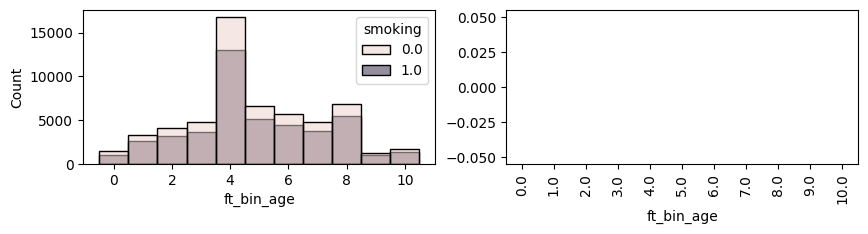

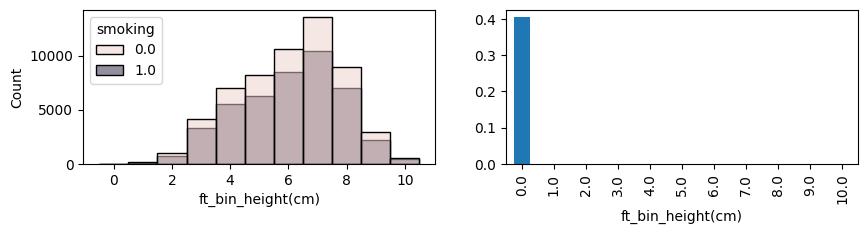

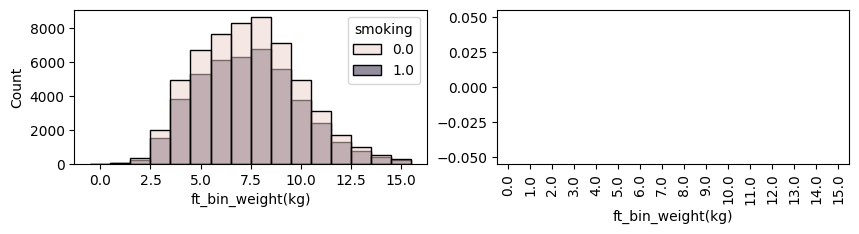

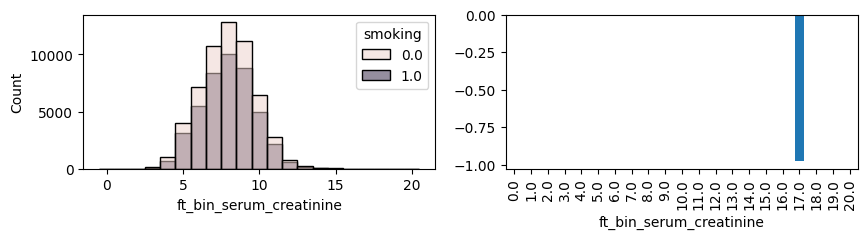

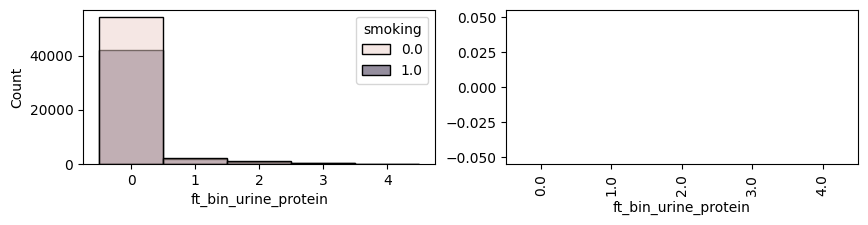

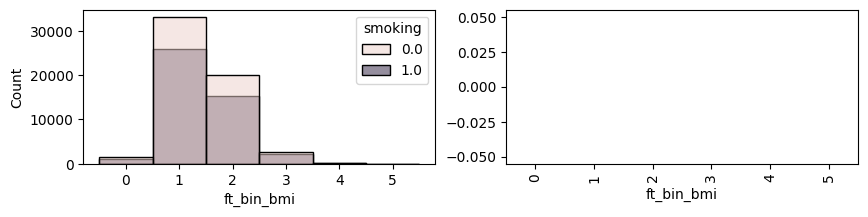

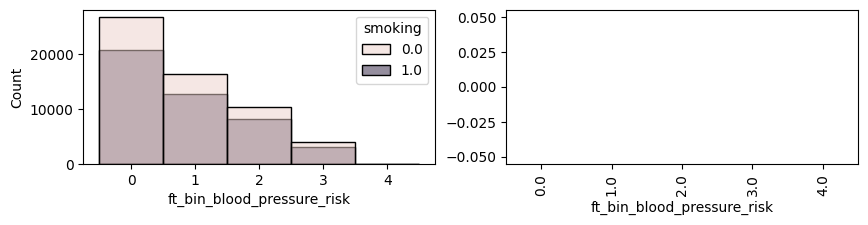

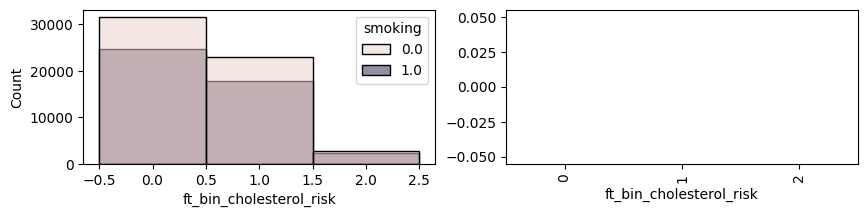

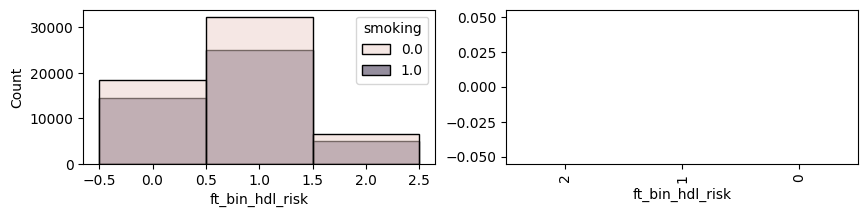

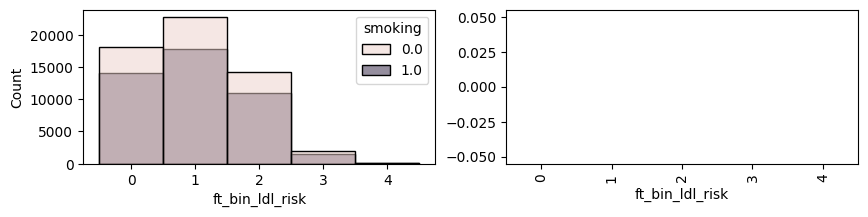

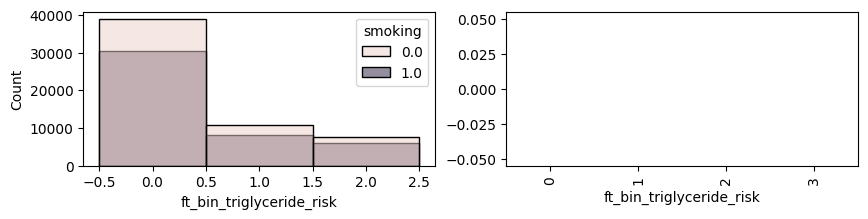

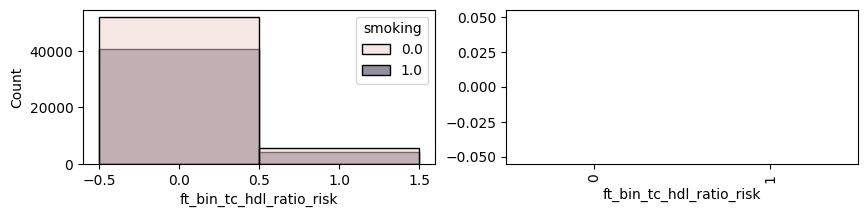

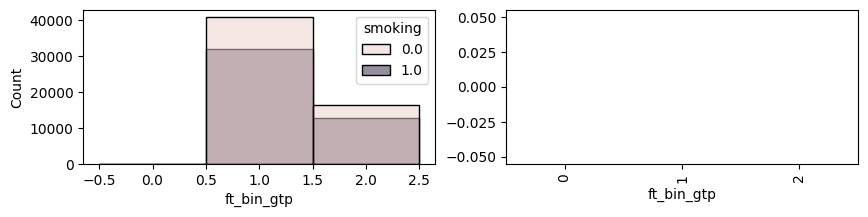

In [16]:
for c in X_train.columns[X_train.columns.str.startswith("ft_bin_")].tolist():
    fig, ax = plt.subplots(1, 2, figsize=[10, 2])

    df_tmp = pd.concat([df_train[[c]], y_train.to_frame("smoking")], axis=1)
    try:
        df_tmp[c] = pd.to_numeric(df_tmp[c], errors="raise")
    except:
        df_tmp[c] = df_tmp[c].astype(str)
    _ = sns.histplot(data=df_tmp, x=c, ax=ax[0], hue="smoking", discrete=True)
    _ = df_train.groupby(c).apply(logodds).plot(kind="bar", ax=ax[1])

In [17]:
fteng_nuniq = X_train.apply("nunique")

mi = mutual_info_classif(X_train, y_train, discrete_features=fteng_nuniq < 10, n_neighbors=5, random_state=rng)
mi_tab = PrettyTable(field_names=["Variable", "Mutual Info"], sortby="Mutual Info", reversesort=True)
mi_tab.add_rows(list(zip(X_train.columns, np.round(mi, 4))))
print(mi_tab)

+----------------------------+-------------+
|          Variable          | Mutual Info |
+----------------------------+-------------+
|           ft_bmi           |     0.14    |
|     ft_bin_height(cm)      |    0.1361   |
|         hemoglobin         |    0.1323   |
|            gtp             |    0.0989   |
|     ft_bin_weight(kg)      |    0.0792   |
|        triglyceride        |    0.0747   |
|  ft_bin_serum_creatinine   |    0.0611   |
|         ft_bin_gtp         |    0.0494   |
|         waist(cm)          |    0.0441   |
|      ft_tc_hdl_ratio       |    0.0438   |
|            hdl             |    0.0396   |
|  ft_bin_triglyceride_risk  |    0.0358   |
|      ft_bin_hdl_risk       |    0.031    |
|            alt             |    0.0309   |
|         ft_bin_age         |    0.0239   |
|         relaxation         |    0.013    |
|      eyesight(right)       |    0.0128   |
|       eyesight(left)       |    0.0107   |
|          systolic          |    0.0104   |
|    fasti

# Modelling

In [18]:
raw_vars = [
    'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic',
    'relaxation', 'fasting_blood_sugar', 'cholesterol', 'triglyceride',
    'hdl', 'ldl', 'hemoglobin', 'ast', 'alt', 'gtp', 'dental_caries',
    'ft_hearing(left)', 'ft_hearing(right)',
    'ft_bin_age', 'ft_bin_height(cm)', 'ft_bin_weight(kg)',
    'ft_bin_serum_creatinine', 'ft_bin_urine_protein'
]

outlier_vars = [
    'eyesight(left)', 'eyesight(right)', 'ast', 'alt', 'gtp', 'cholesterol',
    'triglyceride', 'hdl', 'ldl'
]
binary_vars = X_train.columns[fteng_nuniq == 2].tolist()
znorm_vars = list(set(X_train.columns.tolist()) - set(outlier_vars) - set(binary_vars))

scaling_1 = make_column_transformer(
    (RobustScaler(quantile_range=(0.05, 0.90)), outlier_vars),
    (StandardScaler(), znorm_vars),
    remainder="passthrough"
)

class FitExposedPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_

## Logistic Regression RFE (Model 1)

In [ ]:
pipe_1 = FitExposedPipeline([
    ("preproc", scaling_1),
    ("logreg", LogisticRegression(penalty="l1", C=0.01, solver="liblinear", class_weight=None, max_iter=1000))
])

X_1 = pipe_1[0].fit_transform(X_train)

rfe_1_1 = RFECV(pipe_1[1], step=1, min_features_to_select=1, cv=5, n_jobs=-1, scoring="neg_log_loss", verbose=1).fit(X_1, y_train)
pd.DataFrame(rfe_1_1.cv_results_)

Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,-0.566943,0.001671,-0.567375,-0.563900,-0.568694,-0.566636,-0.568108
1,-0.536406,0.001972,-0.539344,-0.533864,-0.537890,-0.535899,-0.535034
2,-0.521322,0.001641,-0.522301,-0.518358,-0.522651,-0.522581,-0.520718
3,-0.518890,0.002027,-0.521253,-0.517008,-0.516268,-0.521020,-0.518898
4,-0.512351,0.001504,-0.512786,-0.509702,-0.514158,-0.513168,-0.511940
5,-0.508633,0.001953,-0.509386,-0.505157,-0.511069,-0.509253,-0.508300
6,-0.507246,0.001915,-0.507805,-0.503955,-0.509843,-0.507789,-0.506840
7,-0.499472,0.004985,-0.498282,-0.494200,-0.508830,-0.499307,-0.496742
8,-0.497097,0.002607,-0.497596,-0.493245,-0.500941,-0.498266,-0.495436
9,-0.496341,0.002388,-0.496649,-0.492662,-0.499829,-0.497444,-0.495121


In [27]:
selected_vars = [
    'eyesight(right)', 'ast', 'alt', 'gtp', 'cholesterol', 'triglyceride', 'hdl', 'ldl', 'ft_bin_hdl_risk',
    'ft_bin_triglyceride_risk', 'relaxation', 'hemoglobin', 'ft_bin_bmi', 'ft_bin_height(cm)', 'systolic',
    'ft_bin_weight(kg)', 'ft_bin_urine_protein', 'ft_bin_blood_pressure_risk', 'ft_tc_hdl_ratio', 'ft_bin_gtp',
    'fasting_blood_sugar', 'ft_bin_serum_creatinine', 'ft_bin_ldl_risk', 'dental_caries', 'ft_bin_tc_hdl_ratio_risk'
]

scaling_1_1 = make_column_transformer(
    (RobustScaler(quantile_range=(0.05, 0.90)), list(set(selected_vars) & set(outlier_vars))),
    (StandardScaler(), list(set(selected_vars) & set(znorm_vars))),
    ("passthrough", list(set(selected_vars) - set(znorm_vars) - set(outlier_vars)))
)

In [ ]:
pipe_1_1 = Pipeline([
    ("pre", scaling_1_1),
    ("logreg", LogisticRegression(solver="lbfgs", max_iter=1000, penalty="l2"))
])

params = {
    "logreg__C": [1.0, 0.1, 0.01, 0.001],
    "logreg__class_weight": [None, "balanced"]
}

grid_1_1 = GridSearchCV(pipe_1_1, params, scoring="neg_log_loss", n_jobs=-1, refit=False, cv=5).fit(X_train, y_train)
pd.DataFrame(grid_1_1.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logreg__C,param_logreg__class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,4.476475,0.597333,0.051474,0.010101,0.1,None,"{'logreg__C': 0.1, 'logreg__class_weight': None}",-0.490958,-0.484085,-0.495155,-0.489632,-0.488804,-0.489727,0.003569,1
0,4.717108,0.739847,0.066439,0.015513,1.0,None,"{'logreg__C': 1.0, 'logreg__class_weight': None}",-0.490968,-0.484086,-0.495170,-0.489621,-0.488792,-0.489727,0.003574,2
4,4.218225,0.561234,0.072769,0.012944,0.01,None,"{'logreg__C': 0.01, 'logreg__class_weight': None}",-0.490940,-0.484103,-0.495063,-0.489753,-0.488919,-0.489756,0.003527,3
6,3.145812,0.776431,0.070269,0.015958,0.001,None,"{'logreg__C': 0.001, 'logreg__class_weight': N...",-0.491927,-0.485193,-0.495780,-0.491400,-0.490624,-0.490985,0.003398,4
3,4.529685,1.086776,0.062314,0.015073,0.1,balanced,"{'logreg__C': 0.1, 'logreg__class_weight': 'ba...",-0.495921,-0.488661,-0.500864,-0.494528,-0.494650,-0.494925,0.003892,5
1,3.892021,0.651840,0.055657,0.017150,1.0,balanced,"{'logreg__C': 1.0, 'logreg__class_weight': 'ba...",-0.495932,-0.488661,-0.500881,-0.494515,-0.494644,-0.494927,0.003898,6
5,3.562487,0.700472,0.054738,0.008158,0.01,balanced,"{'logreg__C': 0.01, 'logreg__class_weight': 'b...",-0.495877,-0.488658,-0.500751,-0.494634,-0.494739,-0.494932,0.003853,7
7,2.162135,0.107525,0.048272,0.012792,0.001,balanced,"{'logreg__C': 0.001, 'logreg__class_weight': '...",-0.496720,-0.489640,-0.501350,-0.496186,-0.496332,-0.496046,0.003734,8


In [28]:
final_1_pipe = Pipeline([
    ("pre", scaling_1_1),
    ("logreg", LogisticRegression(solver="lbfgs", max_iter=1000, penalty="l2", C=0.1))
]).fit(X_train, y_train)

final_1_pred = final_1_pipe.predict_proba(X_val)
roc_auc_score(y_val, final_1_pred[:, 1])

0.8374333878783373

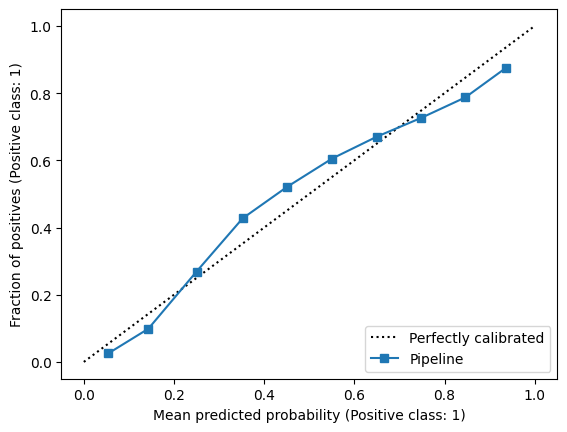

In [ ]:
CalibrationDisplay.from_estimator(final_1_pipe, X_val, y_val, n_bins=10)

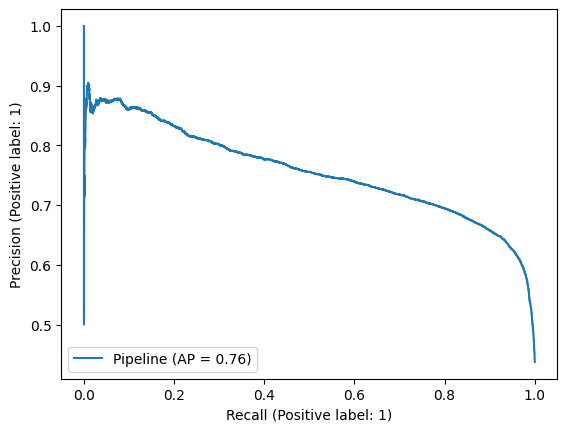

In [ ]:
PrecisionRecallDisplay.from_estimator(final_1_pipe, X_val, y_val)

## LightGBM

In [22]:
# only raw
lgb_baseline_raw = lgb.LGBMClassifier(n_jobs=-1, metric="auc", objective="binary").fit(X_train[raw_vars], y_train)
roc_auc_score(y_val, lgb_baseline_raw.predict_proba(X_val[raw_vars])[:, 1])

[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2121
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251865
[LightGBM] [Info] Start training from score -0.251865


0.8654895142704955

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

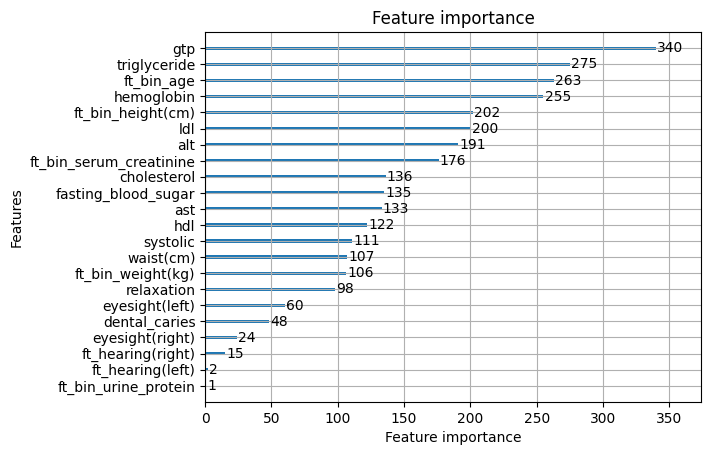

In [60]:
lgb.plot_importance(lgb_baseline_raw)

In [23]:
# all vars
lgb_baseline = lgb.LGBMClassifier(n_jobs=-1, metric="auc", objective="binary").fit(X_train, y_train)
roc_auc_score(y_val, lgb_baseline.predict_proba(X_val)[:, 1])

[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251865
[LightGBM] [Info] Start training from score -0.251865


0.865606162100886

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

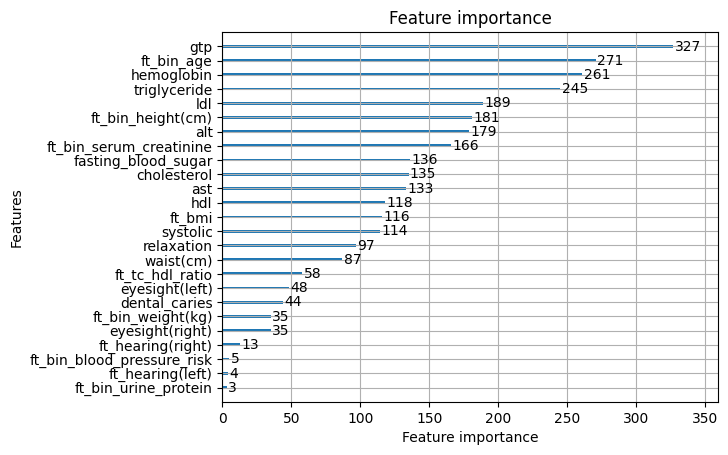

In [61]:
lgb.plot_importance(lgb_baseline)

### Hyperparameter Tuning

In [25]:
lgb_study = opt.create_study(study_name="lgb", direction="minimize")
dtrain = optlgb.Dataset(X_train, label=y_train)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

tuner = optlgb.LightGBMTunerCV(
    params,
    dtrain,
    study=lgb_study,
    nfold=5,
    seed=1234567890,
    callbacks=[lgb.early_stopping(100, min_delta=0.001), lgb.log_evaluation(50)]
)

tuner.run()

[I 2023-11-07 11:51:18,182] A new study created in memory with name: lgb
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452083 + 0.00241482
[100]	cv_agg's valid binary_logloss: 0.44545 + 0.00250739
[150]	cv_agg's valid binary_logloss: 0.444204 + 0.00256314
[200]	cv_agg's valid binary_logloss: 0.443632 + 0.00287038
[250]	cv_agg's valid binary_logloss: 0.443386 + 0.00319198


feature_fraction, val_score: 0.444047:  14%|#4        | 1/7 [00:17<01:47, 17.91s/it]

Early stopping, best iteration is:
[157]	cv_agg's valid binary_logloss: 0.444047 + 0.00259386
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451546 + 0.00270783
[100]	cv_agg's valid binary_logloss: 0.44566 + 0.00300154
[150]	cv_agg's valid binary_logloss: 0.444444 + 0.00304499
[200]	cv_agg's valid binary_logloss: 0.443884 + 0.00309871
[250]	cv_agg's valid binary_logloss: 0.443686 + 0.00302002


feature_fraction, val_score: 0.443986:  29%|##8       | 2/7 [00:45<01:56, 23.40s/it]

Early stopping, best iteration is:
[187]	cv_agg's valid binary_logloss: 0.443986 + 0.00307711
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451461 + 0.00226117
[100]	cv_agg's valid binary_logloss: 0.445498 + 0.00262067
[150]	cv_agg's valid binary_logloss: 0.444398 + 0.00262842
[200]	cv_agg's valid binary_logloss: 0.443984 + 0.00260097


feature_fraction, val_score: 0.443986:  43%|####2     | 3/7 [01:05<01:28, 22.01s/it]

Early stopping, best iteration is:
[135]	cv_agg's valid binary_logloss: 0.444536 + 0.00258194
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451778 + 0.00227797
[100]	cv_agg's valid binary_logloss: 0.446033 + 0.00269869
[150]	cv_agg's valid binary_logloss: 0.445086 + 0.00271742
[200]	cv_agg's valid binary_logloss: 0.44487 + 0.00278263


feature_fraction, val_score: 0.443986:  57%|#####7    | 4/7 [01:23<01:01, 20.62s/it]

Early stopping, best iteration is:
[138]	cv_agg's valid binary_logloss: 0.445262 + 0.00267604
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.454135 + 0.00194188
[100]	cv_agg's valid binary_logloss: 0.445549 + 0.00221675
[150]	cv_agg's valid binary_logloss: 0.443914 + 0.00227082
[200]	cv_agg's valid binary_logloss: 0.443218 + 0.00226647
[250]	cv_agg's valid binary_logloss: 0.442656 + 0.00229197
[300]	cv_agg's valid binary_logloss: 0.442405 + 0.00232716


feature_fraction, val_score: 0.443141:  71%|#######1  | 5/7 [01:44<00:41, 20.70s/it]

Early stopping, best iteration is:
[207]	cv_agg's valid binary_logloss: 0.443141 + 0.00229528
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451654 + 0.00270389
[100]	cv_agg's valid binary_logloss: 0.446164 + 0.00291337
[150]	cv_agg's valid binary_logloss: 0.444945 + 0.00298062
[200]	cv_agg's valid binary_logloss: 0.444542 + 0.00304694
[250]	cv_agg's valid binary_logloss: 0.44425 + 0.00304883
[300]	cv_agg's valid binary_logloss: 0.444153 + 0.00301


feature_fraction, val_score: 0.443141:  86%|########5 | 6/7 [02:09<00:21, 21.98s/it]

Early stopping, best iteration is:
[210]	cv_agg's valid binary_logloss: 0.444473 + 0.00308335
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452887 + 0.0021652
[100]	cv_agg's valid binary_logloss: 0.445518 + 0.00217278
[150]	cv_agg's valid binary_logloss: 0.443947 + 0.00235499
[200]	cv_agg's valid binary_logloss: 0.443451 + 0.00235777


feature_fraction, val_score: 0.443141: 100%|##########| 7/7 [02:26<00:00, 20.94s/it]


Early stopping, best iteration is:
[143]	cv_agg's valid binary_logloss: 0.44404 + 0.00234771


num_leaves, val_score: 0.443141:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.476618 + 0.00222456
[100]	cv_agg's valid binary_logloss: 0.462345 + 0.00235961
[150]	cv_agg's valid binary_logloss: 0.457071 + 0.00239398
[200]	cv_agg's valid binary_logloss: 0.454372 + 0.00238284
[250]	cv_agg's valid binary_logloss: 0.452664 + 0.00239796
[300]	cv_agg's valid binary_logloss: 0.451364 + 0.0023895
[350]	cv_agg's valid binary_logloss: 0.450451 + 0.00237112
[400]	cv_agg's valid binary_logloss: 0.44967 + 0.00228471
[450]	cv_agg's valid binary_logloss: 0.449071 + 0.00220271
[500]	cv_agg's valid binary_logloss: 0.4486 + 0.00224494
[550]	cv_agg's valid binary_logloss: 0.44807 + 0.00230851
[600]	cv_agg's valid binary_logloss: 0.44758 + 0.00227015
[650]	cv_agg's valid binary_logloss: 0.447221 + 0.00225831


num_leaves, val_score: 0.443141:   5%|5         | 1/20 [00:34<10:56, 34.54s/it]

[700]	cv_agg's valid binary_logloss: 0.446852 + 0.00230011
Early stopping, best iteration is:
[600]	cv_agg's valid binary_logloss: 0.44758 + 0.00227015
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.450229 + 0.00203722
[100]	cv_agg's valid binary_logloss: 0.444314 + 0.00216768
[150]	cv_agg's valid binary_logloss: 0.443425 + 0.00225092


num_leaves, val_score: 0.443141:  10%|#         | 2/20 [00:53<07:40, 25.58s/it]

[200]	cv_agg's valid binary_logloss: 0.443729 + 0.00226854
Early stopping, best iteration is:
[103]	cv_agg's valid binary_logloss: 0.444198 + 0.00227202
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.45048 + 0.00208687
[100]	cv_agg's valid binary_logloss: 0.443995 + 0.00229408
[150]	cv_agg's valid binary_logloss: 0.443262 + 0.00225327


num_leaves, val_score: 0.443141:  15%|#5        | 3/20 [01:11<06:13, 21.96s/it]

[200]	cv_agg's valid binary_logloss: 0.44339 + 0.00219586
Early stopping, best iteration is:
[100]	cv_agg's valid binary_logloss: 0.443995 + 0.00229408
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.448944 + 0.001886
[100]	cv_agg's valid binary_logloss: 0.444915 + 0.00226278
[150]	cv_agg's valid binary_logloss: 0.445684 + 0.00284394


num_leaves, val_score: 0.443141:  20%|##        | 4/20 [01:33<05:52, 22.00s/it]

Early stopping, best iteration is:
[73]	cv_agg's valid binary_logloss: 0.445712 + 0.00228957
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.449031 + 0.00184584
[100]	cv_agg's valid binary_logloss: 0.445092 + 0.00233218
[150]	cv_agg's valid binary_logloss: 0.445667 + 0.00248369


num_leaves, val_score: 0.443141:  25%|##5       | 5/20 [01:53<05:16, 21.08s/it]

Early stopping, best iteration is:
[71]	cv_agg's valid binary_logloss: 0.445768 + 0.0020615
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.449158 + 0.00195441
[100]	cv_agg's valid binary_logloss: 0.44433 + 0.00222903
[150]	cv_agg's valid binary_logloss: 0.444389 + 0.00221225


num_leaves, val_score: 0.443141:  30%|###       | 6/20 [02:14<04:57, 21.26s/it]

Early stopping, best iteration is:
[90]	cv_agg's valid binary_logloss: 0.444536 + 0.00202204
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.467045 + 0.00201362
[100]	cv_agg's valid binary_logloss: 0.454437 + 0.0021299
[150]	cv_agg's valid binary_logloss: 0.450699 + 0.00204965
[200]	cv_agg's valid binary_logloss: 0.449049 + 0.00201687
[250]	cv_agg's valid binary_logloss: 0.447905 + 0.00194791
[300]	cv_agg's valid binary_logloss: 0.447136 + 0.00199452
[350]	cv_agg's valid binary_logloss: 0.446492 + 0.00199748
[400]	cv_agg's valid binary_logloss: 0.44586 + 0.00198382
[450]	cv_agg's valid binary_logloss: 0.445379 + 0.00197722
[500]	cv_agg's valid binary_logloss: 0.444928 + 0.00199119


num_leaves, val_score: 0.443141:  35%|###5      | 7/20 [02:42<05:04, 23.45s/it]

Early stopping, best iteration is:
[436]	cv_agg's valid binary_logloss: 0.445532 + 0.00198809
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.449271 + 0.002118
[100]	cv_agg's valid binary_logloss: 0.44421 + 0.00244701
[150]	cv_agg's valid binary_logloss: 0.444107 + 0.00262891


num_leaves, val_score: 0.443141:  40%|####      | 8/20 [03:05<04:37, 23.13s/it]

Early stopping, best iteration is:
[94]	cv_agg's valid binary_logloss: 0.444203 + 0.00234662
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.449104 + 0.00198281
[100]	cv_agg's valid binary_logloss: 0.444338 + 0.00199698
[150]	cv_agg's valid binary_logloss: 0.444561 + 0.0021014


num_leaves, val_score: 0.443141:  45%|####5     | 9/20 [03:25<04:04, 22.20s/it]

Early stopping, best iteration is:
[93]	cv_agg's valid binary_logloss: 0.444334 + 0.00202232
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451968 + 0.00203798
[100]	cv_agg's valid binary_logloss: 0.444285 + 0.00235438
[150]	cv_agg's valid binary_logloss: 0.443204 + 0.00236
[200]	cv_agg's valid binary_logloss: 0.442602 + 0.0024048
[250]	cv_agg's valid binary_logloss: 0.442399 + 0.0025222


num_leaves, val_score: 0.443003:  50%|#####     | 10/20 [03:51<03:55, 23.53s/it]

Early stopping, best iteration is:
[163]	cv_agg's valid binary_logloss: 0.443003 + 0.00244212
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451165 + 0.00195826
[100]	cv_agg's valid binary_logloss: 0.444183 + 0.00219911
[150]	cv_agg's valid binary_logloss: 0.442955 + 0.00232714
[200]	cv_agg's valid binary_logloss: 0.442864 + 0.00255332
[250]	cv_agg's valid binary_logloss: 0.442867 + 0.00261885


num_leaves, val_score: 0.442916:  55%|#####5    | 11/20 [04:13<03:26, 22.94s/it]

Early stopping, best iteration is:
[158]	cv_agg's valid binary_logloss: 0.442916 + 0.00231926
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451564 + 0.0019881
[100]	cv_agg's valid binary_logloss: 0.444369 + 0.00209191
[150]	cv_agg's valid binary_logloss: 0.443162 + 0.0023675
[200]	cv_agg's valid binary_logloss: 0.442622 + 0.00247398


num_leaves, val_score: 0.442916:  60%|######    | 12/20 [04:31<02:52, 21.55s/it]

Early stopping, best iteration is:
[148]	cv_agg's valid binary_logloss: 0.443196 + 0.00239444
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452083 + 0.00196915
[100]	cv_agg's valid binary_logloss: 0.444146 + 0.00200415
[150]	cv_agg's valid binary_logloss: 0.442915 + 0.00202972
[200]	cv_agg's valid binary_logloss: 0.442566 + 0.00195285
[250]	cv_agg's valid binary_logloss: 0.442277 + 0.00197918


num_leaves, val_score: 0.442556:  65%|######5   | 13/20 [04:54<02:33, 21.91s/it]

Early stopping, best iteration is:
[187]	cv_agg's valid binary_logloss: 0.442556 + 0.00195247
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452455 + 0.00213173
[100]	cv_agg's valid binary_logloss: 0.44442 + 0.00226183
[150]	cv_agg's valid binary_logloss: 0.443015 + 0.00223299
[200]	cv_agg's valid binary_logloss: 0.442579 + 0.00211903
[250]	cv_agg's valid binary_logloss: 0.442421 + 0.0022676


num_leaves, val_score: 0.442556:  70%|#######   | 14/20 [05:12<02:04, 20.78s/it]

Early stopping, best iteration is:
[161]	cv_agg's valid binary_logloss: 0.442931 + 0.00219759
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452083 + 0.00196915
[100]	cv_agg's valid binary_logloss: 0.444146 + 0.00200415
[150]	cv_agg's valid binary_logloss: 0.442915 + 0.00202972
[200]	cv_agg's valid binary_logloss: 0.442566 + 0.00195285
[250]	cv_agg's valid binary_logloss: 0.442277 + 0.00197918


num_leaves, val_score: 0.442556:  75%|#######5  | 15/20 [05:35<01:47, 21.44s/it]

Early stopping, best iteration is:
[187]	cv_agg's valid binary_logloss: 0.442556 + 0.00195247
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.450227 + 0.00203287
[100]	cv_agg's valid binary_logloss: 0.443762 + 0.00224181
[150]	cv_agg's valid binary_logloss: 0.443011 + 0.00228467
[200]	cv_agg's valid binary_logloss: 0.443121 + 0.00257591


num_leaves, val_score: 0.442556:  80%|########  | 16/20 [05:53<01:21, 20.42s/it]

Early stopping, best iteration is:
[115]	cv_agg's valid binary_logloss: 0.443335 + 0.00235105
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453764 + 0.00206219
[100]	cv_agg's valid binary_logloss: 0.445375 + 0.0024064
[150]	cv_agg's valid binary_logloss: 0.443688 + 0.00244372
[200]	cv_agg's valid binary_logloss: 0.443104 + 0.00252036
[250]	cv_agg's valid binary_logloss: 0.442721 + 0.00270728
[300]	cv_agg's valid binary_logloss: 0.442518 + 0.00285639


num_leaves, val_score: 0.442556:  85%|########5 | 17/20 [06:17<01:04, 21.48s/it]

Early stopping, best iteration is:
[215]	cv_agg's valid binary_logloss: 0.442971 + 0.00259822
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.449514 + 0.0018988
[100]	cv_agg's valid binary_logloss: 0.443968 + 0.00214573
[150]	cv_agg's valid binary_logloss: 0.443695 + 0.00245585


num_leaves, val_score: 0.442556:  90%|######### | 18/20 [06:35<00:40, 20.49s/it]

Early stopping, best iteration is:
[85]	cv_agg's valid binary_logloss: 0.444506 + 0.00208371
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.450556 + 0.00192448
[100]	cv_agg's valid binary_logloss: 0.443615 + 0.00196842
[150]	cv_agg's valid binary_logloss: 0.442917 + 0.00198714
[200]	cv_agg's valid binary_logloss: 0.442772 + 0.00218457


num_leaves, val_score: 0.442556:  95%|#########5| 19/20 [06:57<00:20, 20.82s/it]

Early stopping, best iteration is:
[126]	cv_agg's valid binary_logloss: 0.443072 + 0.00195623
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.449755 + 0.00206013
[100]	cv_agg's valid binary_logloss: 0.443963 + 0.00229583
[150]	cv_agg's valid binary_logloss: 0.443705 + 0.00232329
[200]	cv_agg's valid binary_logloss: 0.443989 + 0.00233476


num_leaves, val_score: 0.442556: 100%|##########| 20/20 [07:20<00:00, 22.01s/it]


Early stopping, best iteration is:
[109]	cv_agg's valid binary_logloss: 0.443838 + 0.00226536


bagging, val_score: 0.442556:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452369 + 0.00197318
[100]	cv_agg's valid binary_logloss: 0.444747 + 0.00197769
[150]	cv_agg's valid binary_logloss: 0.443149 + 0.00214378
[200]	cv_agg's valid binary_logloss: 0.442817 + 0.00232421
[250]	cv_agg's valid binary_logloss: 0.442686 + 0.00219478


bagging, val_score: 0.442556:  10%|#         | 1/10 [00:20<03:08, 20.90s/it]

Early stopping, best iteration is:
[167]	cv_agg's valid binary_logloss: 0.442945 + 0.00211669
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452017 + 0.00185739
[100]	cv_agg's valid binary_logloss: 0.444166 + 0.00201616
[150]	cv_agg's valid binary_logloss: 0.443047 + 0.00206118
[200]	cv_agg's valid binary_logloss: 0.442761 + 0.0021163


bagging, val_score: 0.442556:  20%|##        | 2/10 [00:45<03:02, 22.84s/it]

Early stopping, best iteration is:
[118]	cv_agg's valid binary_logloss: 0.443486 + 0.00206305
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453304 + 0.00228303
[100]	cv_agg's valid binary_logloss: 0.446721 + 0.00247556
[150]	cv_agg's valid binary_logloss: 0.445726 + 0.00262701
[200]	cv_agg's valid binary_logloss: 0.44582 + 0.00299485
[250]	cv_agg's valid binary_logloss: 0.446344 + 0.00327052


bagging, val_score: 0.442556:  30%|###       | 3/10 [01:09<02:46, 23.73s/it]

Early stopping, best iteration is:
[190]	cv_agg's valid binary_logloss: 0.445679 + 0.00295492
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451903 + 0.00203674
[100]	cv_agg's valid binary_logloss: 0.444208 + 0.00217483
[150]	cv_agg's valid binary_logloss: 0.442782 + 0.00256161
[200]	cv_agg's valid binary_logloss: 0.442278 + 0.0025583
[250]	cv_agg's valid binary_logloss: 0.442045 + 0.002485


bagging, val_score: 0.442326:  40%|####      | 4/10 [01:33<02:21, 23.60s/it]

Early stopping, best iteration is:
[186]	cv_agg's valid binary_logloss: 0.442326 + 0.00249523
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452128 + 0.00217275
[100]	cv_agg's valid binary_logloss: 0.444345 + 0.00248394
[150]	cv_agg's valid binary_logloss: 0.442892 + 0.00273445
[200]	cv_agg's valid binary_logloss: 0.442344 + 0.00280053


bagging, val_score: 0.442326:  50%|#####     | 5/10 [01:51<01:48, 21.76s/it]

Early stopping, best iteration is:
[124]	cv_agg's valid binary_logloss: 0.443254 + 0.00261869
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452603 + 0.00202493
[100]	cv_agg's valid binary_logloss: 0.444963 + 0.00212297
[150]	cv_agg's valid binary_logloss: 0.443554 + 0.00218507
[200]	cv_agg's valid binary_logloss: 0.44306 + 0.00227246


bagging, val_score: 0.442326:  60%|######    | 6/10 [02:20<01:36, 24.07s/it]

Early stopping, best iteration is:
[137]	cv_agg's valid binary_logloss: 0.443688 + 0.00217695
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452576 + 0.00205966
[100]	cv_agg's valid binary_logloss: 0.444911 + 0.00212312
[150]	cv_agg's valid binary_logloss: 0.443656 + 0.00202413
[200]	cv_agg's valid binary_logloss: 0.443147 + 0.00205393


bagging, val_score: 0.442326:  70%|#######   | 7/10 [02:43<01:10, 23.64s/it]

Early stopping, best iteration is:
[141]	cv_agg's valid binary_logloss: 0.443765 + 0.00202414
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.45234 + 0.00210962
[100]	cv_agg's valid binary_logloss: 0.444597 + 0.00212996
[150]	cv_agg's valid binary_logloss: 0.443512 + 0.0024677
[200]	cv_agg's valid binary_logloss: 0.442845 + 0.00240934
[250]	cv_agg's valid binary_logloss: 0.442697 + 0.00229085


bagging, val_score: 0.442326:  80%|########  | 8/10 [03:11<00:50, 25.00s/it]

Early stopping, best iteration is:
[189]	cv_agg's valid binary_logloss: 0.44297 + 0.0023847
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452501 + 0.00211262
[100]	cv_agg's valid binary_logloss: 0.445221 + 0.00246543
[150]	cv_agg's valid binary_logloss: 0.443886 + 0.00272365
[200]	cv_agg's valid binary_logloss: 0.443584 + 0.00287917


bagging, val_score: 0.442326:  90%|######### | 9/10 [03:33<00:24, 24.15s/it]

Early stopping, best iteration is:
[139]	cv_agg's valid binary_logloss: 0.444117 + 0.00277495
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.45225 + 0.00213178
[100]	cv_agg's valid binary_logloss: 0.44443 + 0.00250414
[150]	cv_agg's valid binary_logloss: 0.443086 + 0.00269652
[200]	cv_agg's valid binary_logloss: 0.442526 + 0.00286155
[250]	cv_agg's valid binary_logloss: 0.442164 + 0.00270242


bagging, val_score: 0.442326: 100%|##########| 10/10 [04:01<00:00, 24.10s/it]


Early stopping, best iteration is:
[176]	cv_agg's valid binary_logloss: 0.442859 + 0.0028875


feature_fraction_stage2, val_score: 0.442326:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.450994 + 0.00192484
[100]	cv_agg's valid binary_logloss: 0.44448 + 0.00227512
[150]	cv_agg's valid binary_logloss: 0.443149 + 0.0021726
[200]	cv_agg's valid binary_logloss: 0.442966 + 0.00219092


feature_fraction_stage2, val_score: 0.442326:  33%|###3      | 1/3 [00:19<00:38, 19.37s/it]

Early stopping, best iteration is:
[148]	cv_agg's valid binary_logloss: 0.443186 + 0.00215175
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451903 + 0.00203674
[100]	cv_agg's valid binary_logloss: 0.444208 + 0.00217483
[150]	cv_agg's valid binary_logloss: 0.442782 + 0.00256161
[200]	cv_agg's valid binary_logloss: 0.442278 + 0.0025583
[250]	cv_agg's valid binary_logloss: 0.442045 + 0.002485


feature_fraction_stage2, val_score: 0.442326:  67%|######6   | 2/3 [00:41<00:21, 21.11s/it]

Early stopping, best iteration is:
[186]	cv_agg's valid binary_logloss: 0.442326 + 0.00249523
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.451474 + 0.00215967
[100]	cv_agg's valid binary_logloss: 0.444381 + 0.00247797
[150]	cv_agg's valid binary_logloss: 0.443169 + 0.00279025
[200]	cv_agg's valid binary_logloss: 0.442882 + 0.00284361


feature_fraction_stage2, val_score: 0.442326: 100%|##########| 3/3 [01:01<00:00, 20.51s/it]


Early stopping, best iteration is:
[118]	cv_agg's valid binary_logloss: 0.443783 + 0.00257745


regularization_factors, val_score: 0.442326:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452045 + 0.00211503
[100]	cv_agg's valid binary_logloss: 0.443694 + 0.00222098
[150]	cv_agg's valid binary_logloss: 0.441858 + 0.00252747
[200]	cv_agg's valid binary_logloss: 0.441214 + 0.00262876
[250]	cv_agg's valid binary_logloss: 0.440733 + 0.00267342
[300]	cv_agg's valid binary_logloss: 0.440474 + 0.0028551


regularization_factors, val_score: 0.441069:   5%|5         | 1/20 [00:22<07:07, 22.52s/it]

Early stopping, best iteration is:
[207]	cv_agg's valid binary_logloss: 0.441069 + 0.00266897
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452159 + 0.00212638
[100]	cv_agg's valid binary_logloss: 0.443821 + 0.00239572
[150]	cv_agg's valid binary_logloss: 0.441804 + 0.00247624
[200]	cv_agg's valid binary_logloss: 0.440942 + 0.00254826
[250]	cv_agg's valid binary_logloss: 0.440545 + 0.00268323


regularization_factors, val_score: 0.441032:  10%|#         | 2/20 [00:46<07:04, 23.60s/it]

Early stopping, best iteration is:
[189]	cv_agg's valid binary_logloss: 0.441032 + 0.00251621
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452347 + 0.00208166
[100]	cv_agg's valid binary_logloss: 0.443618 + 0.00236162
[150]	cv_agg's valid binary_logloss: 0.441436 + 0.00245978
[200]	cv_agg's valid binary_logloss: 0.44066 + 0.00250737
[250]	cv_agg's valid binary_logloss: 0.440186 + 0.00253621
[300]	cv_agg's valid binary_logloss: 0.439832 + 0.00252451


regularization_factors, val_score: 0.440265:  15%|#5        | 3/20 [01:13<07:07, 25.16s/it]

Early stopping, best iteration is:
[233]	cv_agg's valid binary_logloss: 0.440265 + 0.00246546
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452436 + 0.00207768
[100]	cv_agg's valid binary_logloss: 0.44387 + 0.00228278
[150]	cv_agg's valid binary_logloss: 0.441625 + 0.00235743
[200]	cv_agg's valid binary_logloss: 0.44064 + 0.00250991
[250]	cv_agg's valid binary_logloss: 0.440029 + 0.00251113
[300]	cv_agg's valid binary_logloss: 0.439721 + 0.0025532


regularization_factors, val_score: 0.440142:  20%|##        | 4/20 [01:43<07:12, 27.05s/it]

Early stopping, best iteration is:
[241]	cv_agg's valid binary_logloss: 0.440142 + 0.00246017
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.45231 + 0.0019329
[100]	cv_agg's valid binary_logloss: 0.443639 + 0.00230939
[150]	cv_agg's valid binary_logloss: 0.441649 + 0.00228541
[200]	cv_agg's valid binary_logloss: 0.440811 + 0.00235007
[250]	cv_agg's valid binary_logloss: 0.440361 + 0.00238839


regularization_factors, val_score: 0.440142:  25%|##5       | 5/20 [02:05<06:15, 25.01s/it]

Early stopping, best iteration is:
[185]	cv_agg's valid binary_logloss: 0.440989 + 0.00230475
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452394 + 0.00208317
[100]	cv_agg's valid binary_logloss: 0.443809 + 0.00244394
[150]	cv_agg's valid binary_logloss: 0.441691 + 0.00245891
[200]	cv_agg's valid binary_logloss: 0.440646 + 0.00246635
[250]	cv_agg's valid binary_logloss: 0.440121 + 0.00257754


regularization_factors, val_score: 0.440142:  30%|###       | 6/20 [02:29<05:45, 24.66s/it]

Early stopping, best iteration is:
[171]	cv_agg's valid binary_logloss: 0.441073 + 0.00255556
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452275 + 0.00204806
[100]	cv_agg's valid binary_logloss: 0.443639 + 0.00234943
[150]	cv_agg's valid binary_logloss: 0.441544 + 0.00235757
[200]	cv_agg's valid binary_logloss: 0.440482 + 0.00229088
[250]	cv_agg's valid binary_logloss: 0.440114 + 0.0022316
[300]	cv_agg's valid binary_logloss: 0.439791 + 0.00234554
[350]	cv_agg's valid binary_logloss: 0.439483 + 0.00231614


regularization_factors, val_score: 0.439968:  35%|###5      | 7/20 [03:04<06:04, 28.05s/it]

Early stopping, best iteration is:
[269]	cv_agg's valid binary_logloss: 0.439968 + 0.00227754
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452337 + 0.00203955
[100]	cv_agg's valid binary_logloss: 0.443765 + 0.00241931
[150]	cv_agg's valid binary_logloss: 0.441625 + 0.00250631
[200]	cv_agg's valid binary_logloss: 0.440619 + 0.00250086
[250]	cv_agg's valid binary_logloss: 0.440132 + 0.00261236
[300]	cv_agg's valid binary_logloss: 0.439952 + 0.00274011


regularization_factors, val_score: 0.439968:  40%|####      | 8/20 [03:31<05:34, 27.90s/it]

Early stopping, best iteration is:
[243]	cv_agg's valid binary_logloss: 0.440166 + 0.00260537
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452349 + 0.00201795
[100]	cv_agg's valid binary_logloss: 0.443712 + 0.00215921
[150]	cv_agg's valid binary_logloss: 0.441421 + 0.00240795
[200]	cv_agg's valid binary_logloss: 0.440481 + 0.00253058
[250]	cv_agg's valid binary_logloss: 0.440026 + 0.00270457
[300]	cv_agg's valid binary_logloss: 0.439598 + 0.00271825


regularization_factors, val_score: 0.439968:  45%|####5     | 9/20 [03:59<05:05, 27.74s/it]

Early stopping, best iteration is:
[237]	cv_agg's valid binary_logloss: 0.440105 + 0.00262031
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452722 + 0.00211161
[100]	cv_agg's valid binary_logloss: 0.443869 + 0.00245324
[150]	cv_agg's valid binary_logloss: 0.44116 + 0.00253108
[200]	cv_agg's valid binary_logloss: 0.440013 + 0.00259673
[250]	cv_agg's valid binary_logloss: 0.439319 + 0.0026225
[300]	cv_agg's valid binary_logloss: 0.439027 + 0.00265014


regularization_factors, val_score: 0.439524:  50%|#####     | 10/20 [04:27<04:38, 27.89s/it]

Early stopping, best iteration is:
[237]	cv_agg's valid binary_logloss: 0.439524 + 0.00257867
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453411 + 0.00215238
[100]	cv_agg's valid binary_logloss: 0.444155 + 0.00231649
[150]	cv_agg's valid binary_logloss: 0.441418 + 0.00243587
[200]	cv_agg's valid binary_logloss: 0.440124 + 0.00249273
[250]	cv_agg's valid binary_logloss: 0.439286 + 0.00257512
[300]	cv_agg's valid binary_logloss: 0.438912 + 0.00274686


regularization_factors, val_score: 0.439286:  55%|#####5    | 11/20 [04:59<04:22, 29.19s/it]

Early stopping, best iteration is:
[249]	cv_agg's valid binary_logloss: 0.439286 + 0.00255195
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453423 + 0.00234276
[100]	cv_agg's valid binary_logloss: 0.444241 + 0.00260887
[150]	cv_agg's valid binary_logloss: 0.441515 + 0.00279491
[200]	cv_agg's valid binary_logloss: 0.440051 + 0.00290424
[250]	cv_agg's valid binary_logloss: 0.4391 + 0.00296444
[300]	cv_agg's valid binary_logloss: 0.438633 + 0.00304749


regularization_factors, val_score: 0.439113:  60%|######    | 12/20 [05:29<03:54, 29.32s/it]

Early stopping, best iteration is:
[248]	cv_agg's valid binary_logloss: 0.439113 + 0.00294146
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453581 + 0.00208704
[100]	cv_agg's valid binary_logloss: 0.444337 + 0.00238733
[150]	cv_agg's valid binary_logloss: 0.441491 + 0.00266065
[200]	cv_agg's valid binary_logloss: 0.440103 + 0.00268387
[250]	cv_agg's valid binary_logloss: 0.439285 + 0.00281893
[300]	cv_agg's valid binary_logloss: 0.438914 + 0.00285289
[350]	cv_agg's valid binary_logloss: 0.438586 + 0.00291543


regularization_factors, val_score: 0.439113:  65%|######5   | 13/20 [05:59<03:26, 29.53s/it]

Early stopping, best iteration is:
[254]	cv_agg's valid binary_logloss: 0.43922 + 0.00281976
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452755 + 0.00213059
[100]	cv_agg's valid binary_logloss: 0.443774 + 0.00236196
[150]	cv_agg's valid binary_logloss: 0.441253 + 0.00253705
[200]	cv_agg's valid binary_logloss: 0.439924 + 0.00244247
[250]	cv_agg's valid binary_logloss: 0.439294 + 0.00254206
[300]	cv_agg's valid binary_logloss: 0.438944 + 0.00270049


regularization_factors, val_score: 0.439113:  70%|#######   | 14/20 [06:31<03:02, 30.39s/it]

[350]	cv_agg's valid binary_logloss: 0.438795 + 0.00276799
Early stopping, best iteration is:
[251]	cv_agg's valid binary_logloss: 0.439273 + 0.00255053
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453258 + 0.00217713
[100]	cv_agg's valid binary_logloss: 0.444299 + 0.00234494
[150]	cv_agg's valid binary_logloss: 0.441549 + 0.00251002
[200]	cv_agg's valid binary_logloss: 0.440214 + 0.002555
[250]	cv_agg's valid binary_logloss: 0.439406 + 0.00256078
[300]	cv_agg's valid binary_logloss: 0.439 + 0.00266384
[350]	cv_agg's valid binary_logloss: 0.43871 + 0.00276431


regularization_factors, val_score: 0.439113:  75%|#######5  | 15/20 [07:03<02:33, 30.71s/it]

Early stopping, best iteration is:
[272]	cv_agg's valid binary_logloss: 0.439239 + 0.00257949
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453196 + 0.002331
[100]	cv_agg's valid binary_logloss: 0.444051 + 0.00249966
[150]	cv_agg's valid binary_logloss: 0.441263 + 0.0028093
[200]	cv_agg's valid binary_logloss: 0.439809 + 0.00294934
[250]	cv_agg's valid binary_logloss: 0.439016 + 0.0031104
[300]	cv_agg's valid binary_logloss: 0.43861 + 0.0032148
[350]	cv_agg's valid binary_logloss: 0.438199 + 0.00320234


regularization_factors, val_score: 0.438859:  80%|########  | 16/20 [07:36<02:06, 31.54s/it]

Early stopping, best iteration is:
[269]	cv_agg's valid binary_logloss: 0.438859 + 0.00315017
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452643 + 0.00207251
[100]	cv_agg's valid binary_logloss: 0.443783 + 0.0022385
[150]	cv_agg's valid binary_logloss: 0.441284 + 0.0024881
[200]	cv_agg's valid binary_logloss: 0.440161 + 0.00269337
[250]	cv_agg's valid binary_logloss: 0.439557 + 0.00277681
[300]	cv_agg's valid binary_logloss: 0.439176 + 0.00285478
[350]	cv_agg's valid binary_logloss: 0.43905 + 0.00294651


regularization_factors, val_score: 0.438859:  85%|########5 | 17/20 [08:08<01:34, 31.54s/it]

Early stopping, best iteration is:
[295]	cv_agg's valid binary_logloss: 0.439223 + 0.00286146
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452967 + 0.0021743
[100]	cv_agg's valid binary_logloss: 0.444117 + 0.00236959
[150]	cv_agg's valid binary_logloss: 0.441367 + 0.00240152
[200]	cv_agg's valid binary_logloss: 0.439832 + 0.0024974
[250]	cv_agg's valid binary_logloss: 0.439032 + 0.00258778
[300]	cv_agg's valid binary_logloss: 0.438538 + 0.00260517
[350]	cv_agg's valid binary_logloss: 0.438352 + 0.00249857


regularization_factors, val_score: 0.438660:  90%|######### | 18/20 [08:45<01:06, 33.37s/it]

Early stopping, best iteration is:
[285]	cv_agg's valid binary_logloss: 0.43866 + 0.00260984
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453206 + 0.0022323
[100]	cv_agg's valid binary_logloss: 0.444104 + 0.00240901
[150]	cv_agg's valid binary_logloss: 0.441235 + 0.00254914
[200]	cv_agg's valid binary_logloss: 0.439801 + 0.0025741
[250]	cv_agg's valid binary_logloss: 0.439014 + 0.0026345
[300]	cv_agg's valid binary_logloss: 0.438554 + 0.00270838


regularization_factors, val_score: 0.438660:  95%|#########5| 19/20 [09:15<00:32, 32.17s/it]

Early stopping, best iteration is:
[249]	cv_agg's valid binary_logloss: 0.439015 + 0.00262514
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453063 + 0.00209996
[100]	cv_agg's valid binary_logloss: 0.44397 + 0.00227586
[150]	cv_agg's valid binary_logloss: 0.441344 + 0.00249098
[200]	cv_agg's valid binary_logloss: 0.439937 + 0.00247634
[250]	cv_agg's valid binary_logloss: 0.439155 + 0.00270419
[300]	cv_agg's valid binary_logloss: 0.438695 + 0.00277128
[350]	cv_agg's valid binary_logloss: 0.43837 + 0.00274882


regularization_factors, val_score: 0.438660: 100%|##########| 20/20 [09:49<00:00, 29.46s/it]


Early stopping, best iteration is:
[287]	cv_agg's valid binary_logloss: 0.4388 + 0.00273001


min_child_samples, val_score: 0.438660:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.453055 + 0.00219609
[100]	cv_agg's valid binary_logloss: 0.444024 + 0.00250908
[150]	cv_agg's valid binary_logloss: 0.44127 + 0.00273384
[200]	cv_agg's valid binary_logloss: 0.439831 + 0.00282604
[250]	cv_agg's valid binary_logloss: 0.439027 + 0.00279452
[300]	cv_agg's valid binary_logloss: 0.438648 + 0.00284211
[350]	cv_agg's valid binary_logloss: 0.438395 + 0.00290748


min_child_samples, val_score: 0.438660:  20%|##        | 1/5 [00:32<02:09, 32.43s/it]

Early stopping, best iteration is:
[290]	cv_agg's valid binary_logloss: 0.4387 + 0.00282975
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452929 + 0.00207875
[100]	cv_agg's valid binary_logloss: 0.443819 + 0.0022637
[150]	cv_agg's valid binary_logloss: 0.441057 + 0.00246607
[200]	cv_agg's valid binary_logloss: 0.439716 + 0.00246232
[250]	cv_agg's valid binary_logloss: 0.439002 + 0.00243959
[300]	cv_agg's valid binary_logloss: 0.438578 + 0.00243826


min_child_samples, val_score: 0.438660:  40%|####      | 2/5 [01:03<01:35, 31.68s/it]

Early stopping, best iteration is:
[226]	cv_agg's valid binary_logloss: 0.439328 + 0.00248492
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452968 + 0.00217615
[100]	cv_agg's valid binary_logloss: 0.444039 + 0.00236793
[150]	cv_agg's valid binary_logloss: 0.441535 + 0.00259951
[200]	cv_agg's valid binary_logloss: 0.440276 + 0.00274733
[250]	cv_agg's valid binary_logloss: 0.439605 + 0.00282142
[300]	cv_agg's valid binary_logloss: 0.439299 + 0.00283532
[350]	cv_agg's valid binary_logloss: 0.438933 + 0.00285014


min_child_samples, val_score: 0.438660:  60%|######    | 3/5 [01:34<01:03, 31.51s/it]

Early stopping, best iteration is:
[271]	cv_agg's valid binary_logloss: 0.439443 + 0.00285825
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.45295 + 0.00217801
[100]	cv_agg's valid binary_logloss: 0.444182 + 0.00242913
[150]	cv_agg's valid binary_logloss: 0.441411 + 0.00271384
[200]	cv_agg's valid binary_logloss: 0.440058 + 0.00276991
[250]	cv_agg's valid binary_logloss: 0.439312 + 0.00295243
[300]	cv_agg's valid binary_logloss: 0.438787 + 0.00312368
[350]	cv_agg's valid binary_logloss: 0.438351 + 0.00317419


min_child_samples, val_score: 0.438660:  80%|########  | 4/5 [02:09<00:32, 32.72s/it]

Early stopping, best iteration is:
[289]	cv_agg's valid binary_logloss: 0.438868 + 0.0030879
Training until validation scores don't improve for 100 rounds
[50]	cv_agg's valid binary_logloss: 0.452963 + 0.0020462
[100]	cv_agg's valid binary_logloss: 0.443931 + 0.00226023
[150]	cv_agg's valid binary_logloss: 0.441403 + 0.00243853
[200]	cv_agg's valid binary_logloss: 0.440182 + 0.00239652
[250]	cv_agg's valid binary_logloss: 0.439492 + 0.00248907
[300]	cv_agg's valid binary_logloss: 0.439096 + 0.00249344


min_child_samples, val_score: 0.438660: 100%|##########| 5/5 [02:38<00:00, 31.68s/it]

Early stopping, best iteration is:
[241]	cv_agg's valid binary_logloss: 0.439597 + 0.00249945


In [29]:
lgb_tuner_best_params = {'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 7.642538573540911,
 'lambda_l2': 0.04587199867882324,
 'num_leaves': 50,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.990722623935609,
 'bagging_freq': 1,
 'min_child_samples': 20}

final_2_pipe = lgb.LGBMClassifier(**lgb_tuner_best_params).fit(X_train, y_train)
roc_auc_score(y_val, final_2_pipe.predict_proba(X_val)[:, 1])

0.8669604938007638

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

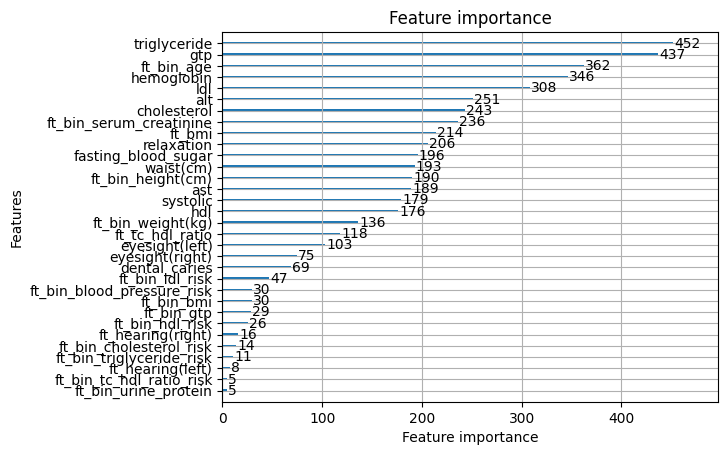

In [62]:
lgb.plot_importance(final_2_pipe)

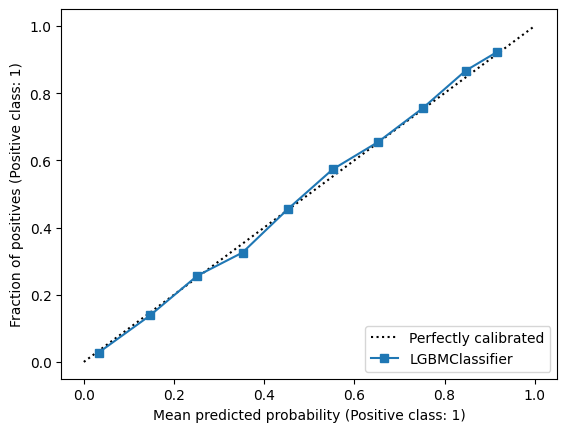

In [39]:
CalibrationDisplay.from_estimator(final_2_pipe, X_val, y_val, n_bins=10)

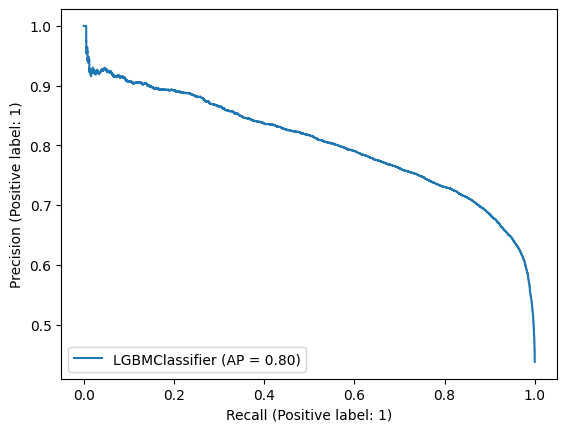

In [40]:
PrecisionRecallDisplay.from_estimator(final_2_pipe, X_val, y_val)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

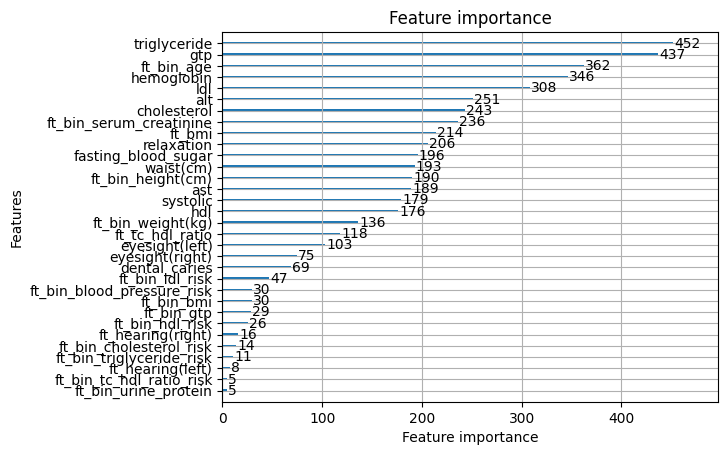

In [55]:
lgb.plot_importance(final_2_pipe)

## XGBoost

In [22]:
catcols = X_train.select_dtypes(["category"]).columns
X_train[catcols] = X_train[catcols].apply(lambda x: x.cat.codes)
X_val[catcols] = X_val[catcols].apply(lambda x: x.cat.codes)
test[catcols] = test[catcols].apply(lambda x: x.cat.codes)

In [42]:
# raw vars only
xgb_baseline_raw = xgb.XGBClassifier(verbosity=0, device="gpu").fit(X_train[raw_vars], y_train)
roc_auc_score(y_val, xgb_baseline_raw.predict_proba(X_val[raw_vars])[:, 1])

0.8645284894781691

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

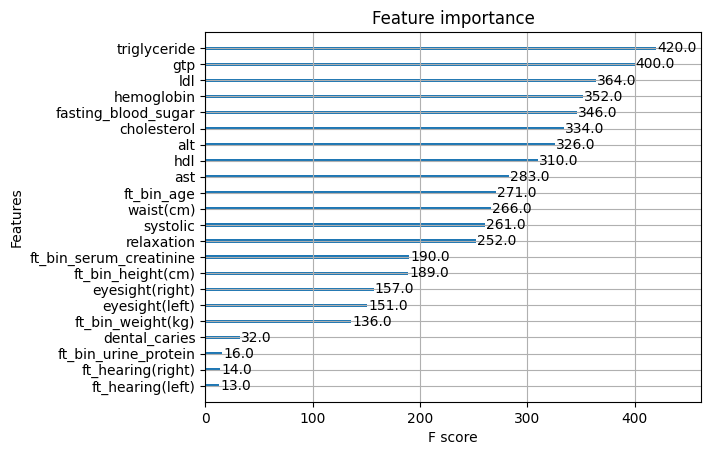

In [58]:
xgb.plot_importance(xgb_baseline_raw)

In [57]:
# all vars
xgb_baseline = xgb.XGBClassifier(verbosity=0, device="gpu").fit(X_train, y_train)
roc_auc_score(y_val, xgb_baseline.predict_proba(X_val)[:, 1])

0.8644710527786331

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

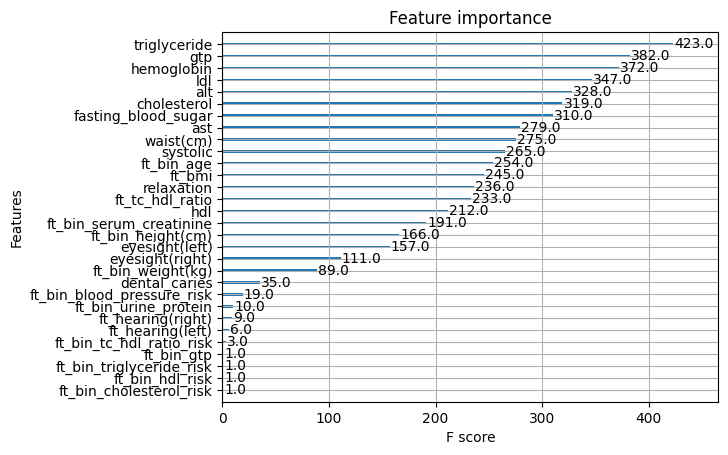

In [59]:
xgb.plot_importance(xgb_baseline)

In [26]:
def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)

    param = {
        "verbosity": 1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "device": "cuda",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    }

    if param["booster"] == "gbtree":
        param["tree_method"] = "hist"
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    pruning_callback = opt.integration.XGBoostPruningCallback(trial, "test-logloss")
    history = xgb.cv(
        param,
        dtrain,
        num_boost_round=1000,
        nfold=5,
        stratified=True,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
        seed=1234567890,
        shuffle=True
    )

    mean_logloss = history["test-logloss-mean"].values[-1]
    return mean_logloss

pruner = opt.pruners.MedianPruner(n_warmup_steps=10)
xgb_study = opt.create_study(pruner=pruner, direction="minimize")
xgb_study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(xgb_study.trials)))

print("Best trial:")
trial = xgb_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-07 17:54:48,036] A new study created in memory with name: no-name-2463a049-1e88-4076-b9be-0d68913681c3
[I 2023-11-07 17:57:11,180] Trial 0 finished with value: 0.49211950769884866 and parameters: {'booster': 'gblinear', 'lambda': 5.247389327529052e-07, 'alpha': 2.2849010260681465e-08}. Best is trial 0 with value: 0.49211950769884866.
[I 2023-11-07 17:59:47,796] Trial 1 finished with value: 0.4932877702651986 and parameters: {'booster': 'gblinear', 'lambda': 0.01629158377732844, 'alpha': 0.00014781237609520764}. Best is trial 0 with value: 0.49211950769884866.
[I 2023-11-07 18:02:08,738] Trial 2 finished with value: 0.5184519288833528 and parameters: {'booster': 'gblinear', 'lambda': 0.802696892589359, 'alpha': 1.4393820466325054e-07}. Best is trial 0 with value: 0.49211950769884866.
[I 2023-11-07 18:02:18,904] Trial 3 finished with value: 0.445950248170689 and parameters: {'booster': 'gbtree', 'lambda': 0.07907555283609088, 'alpha': 0.17906611401715483, 'max_depth': 7, 'eta'

Number of finished trials: 100
Best trial:
  Value: 0.4439376030595549
  Params: 
    booster: gbtree
    lambda: 0.03329374212920203
    alpha: 0.0009103951474898033
    max_depth: 5
    eta: 0.1918450962575436
    gamma: 9.43991006040767e-08
    grow_policy: depthwise


In [30]:
xgb_params = {
    "verbosity": 1,
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    # "device": "cuda",
    "booster": "gbtree",
    "tree_method": "hist",
    "lambda": 0.03329374212920203,
    "alpha": 0.0009103951474898033,
    "max_depth": 5,
    "eta": 0.1918450962575436,
    "gamma": 9.43991006040767e-08,
    "grow_policy": "depthwise"
}

final_3_pipe = xgb.XGBClassifier(**xgb_params).fit(X_train, y_train)
roc_auc_score(y_val, final_3_pipe.predict_proba(X_val)[:, 1])

0.8656007687108845

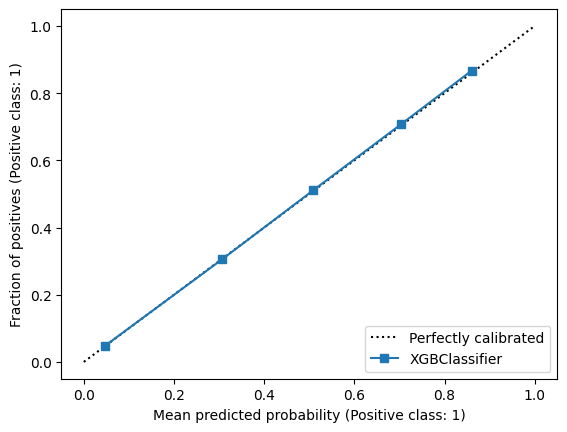

In [28]:
CalibrationDisplay.from_estimator(final_3_pipe, X_val, y_val)

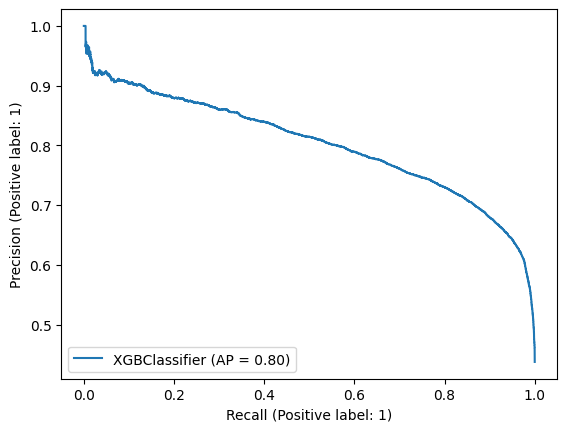

In [29]:
PrecisionRecallDisplay.from_estimator(final_3_pipe, X_val, y_val)

## CatBoost

In [23]:
def objective(trial: opt.Trial) -> float:
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=rng)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Logloss",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = cb.CatBoostClassifier(**param)

    pruning_callback = opt.integration.CatBoostPruningCallback(trial, "Logloss")
    gbm.fit(
        train_x,
        train_y,
        eval_set=[(valid_x, valid_y)],
        verbose=0,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    brier = brier_score_loss(valid_y, pred_labels)

    return brier


cat_study = opt.create_study(
    pruner=opt.pruners.MedianPruner(n_warmup_steps=10), direction="minimize"
)
cat_study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(cat_study.trials)))

print("Best trial:")
trial = cat_study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-11-07 19:00:01,576] A new study created in memory with name: no-name-e5249bf3-1d5c-40a1-8aa6-16bf9956a267
<ipython-input-23-742aaf115af1>:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = opt.integration.CatBoostPruningCallback(trial, "Logloss")
[I 2023-11-07 19:00:20,895] Trial 0 finished with value: 0.2330756249754719 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.03014498529138797, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11272250833496164}. Best is trial 0 with value: 0.2330756249754719.
<ipython-input-23-742aaf115af1>:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = opt.integration.CatBoostPruningCallback(trial, "Logloss")
[I 2023-11-07 19:00:44,580] Trial 1 finished with value: 0.22381382206349829 and paramet

Number of finished trials: 100
Best trial:
  Value: 0.21494446842745576
  Params: 
    objective: Logloss
    colsample_bylevel: 0.0828104825832603
    depth: 8
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    subsample: 0.6622239601492731


In [26]:
cb_params = {
    "objective": "Logloss",
    "colsample_bylevel": 0.0828104825832603,
    "depth": 8,
    "boosting_type": "Ordered",
    "bootstrap_type": "Bernoulli",
    "subsample": 0.6622239601492731,
    "eval_metric": "Logloss"
}

final_4_pipe = cb.CatBoostClassifier(**cb_params).fit(X_train, y_train, verbose=0)
roc_auc_score(y_val, final_4_pipe.predict_proba(X_val)[:, 1])

0.8661535200886114

# Ensemble

In [36]:
final_train_probas = pd.DataFrame({
    "logreg": final_1_pipe.predict_proba(X_train)[:, 1],
    "lgb": final_2_pipe.predict_proba(X_train)[:, 1],
    "xgb": final_3_pipe.predict_proba(X_train)[:, 1],
    "cb": final_4_pipe.predict_proba(X_train)[:, 1]
})

final_val_probas = pd.DataFrame({
    "logreg": final_1_pipe.predict_proba(X_val)[:, 1],
    "lgb": final_2_pipe.predict_proba(X_val)[:, 1],
    "xgb": final_3_pipe.predict_proba(X_val)[:, 1],
    "cb": final_4_pipe.predict_proba(X_val)[:, 1]
})

final_test_probas = pd.DataFrame({
    "logreg": final_1_pipe.predict_proba(test.drop(columns="id"))[:, 1],
    "lgb": final_2_pipe.predict_proba(test.drop(columns="id"))[:, 1],
    "xgb": final_3_pipe.predict_proba(test.drop(columns="id"))[:, 1],
    "cb": final_4_pipe.predict_proba(test.drop(columns="id"))[:, 1]
})

final_train_probas.describe()

,logreg,lgb,xgb,cb
count,1.274040e+05,127404.000000,127404.000000,127404.000000
mean,4.373674e-01,0.437343,0.437350,0.437364
std,2.897596e-01,0.309955,0.314393,0.314783
min,4.498834e-12,0.003150,0.000732,0.000223
25%,1.364666e-01,0.079497,0.070235,0.075902
50%,4.553106e-01,0.489237,0.493066,0.488560
75%,6.884456e-01,0.719952,0.722306,0.722794
max,9.999999e-01,0.964960,0.983150,0.992701


In [37]:
final_train_probas.corr()

,logreg,lgb,xgb,cb
logreg,1.000000,0.921864,0.913155,0.914752
lgb,0.921864,1.000000,0.988652,0.987820
xgb,0.913155,0.988652,1.000000,0.987163
cb,0.914752,0.987820,0.987163,1.000000


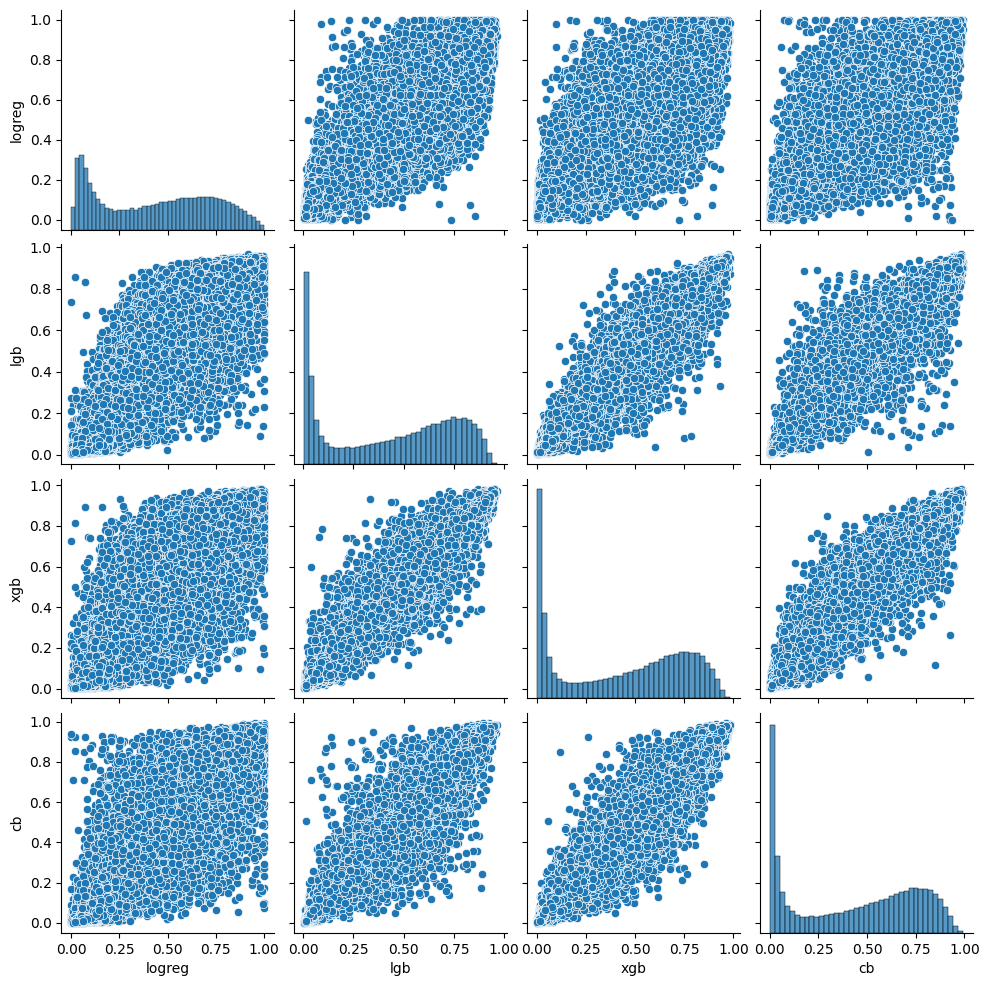

In [33]:
sns.pairplot(final_train_probas)

In [46]:
proba_logreg = LogisticRegression(C=10000.0, max_iter=1000).fit(final_train_probas.drop(columns=["logreg", "lgb"]), y_train)
roc_auc_score(y_val, proba_logreg.predict_proba(final_val_probas.drop(columns=["logreg", "lgb"]))[:, 1])

0.8665226658907128

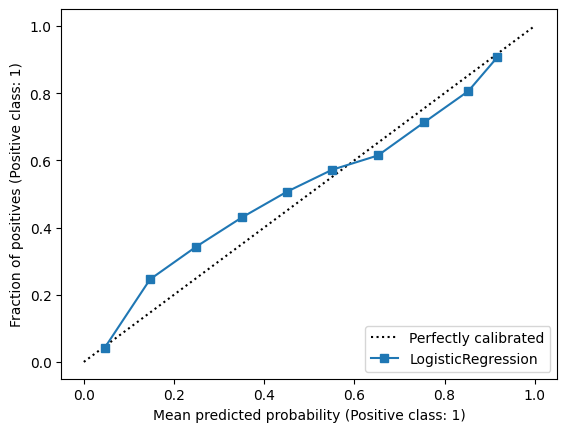

In [51]:
CalibrationDisplay.from_estimator(proba_logreg, final_val_probas.drop(columns=["logreg", "lgb"]), y_val, n_bins=10)

In [53]:
calib_logreg = CalibratedClassifierCV(LogisticRegression(C=10000.0, max_iter=1000), method="isotonic", cv=5, n_jobs=-1).fit(final_train_probas.drop(columns=["logreg", "lgb"]), y_train)
roc_auc_score(y_val, calib_logreg.predict_proba(final_val_probas.drop(columns=["logreg", "lgb"]))[:, 1])

0.8664953965263388

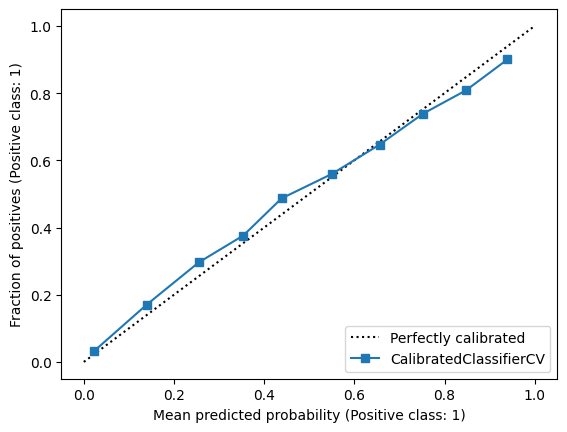

In [54]:
CalibrationDisplay.from_estimator(calib_logreg, final_val_probas.drop(columns=["logreg", "lgb"]), y_val, n_bins=10)

In [59]:
submission = pd.DataFrame({
    "id": test["id"],
    "smoking": calib_logreg.predict_proba(final_test_probas.drop(columns=["logreg", "lgb"]))[:, 1]
})
submission.to_csv(data_p / "submission.csv", index=False)